In [1]:
# NFQ, DQN, Double DQN, Dueling DQN, PER

In [2]:
!nvidia-smi

Sat Jan 19 03:01:08 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 415.18       Driver Version: 415.18       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN X (Pascal)    Off  | 00000000:0B:00.0 Off |                  N/A |
| 23%   37C    P8    17W / 250W |      2MiB / 12196MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN X (Pascal)    Off  | 00000000:41:00.0  On |                  N/A |
| 23%   41C    P8    16W / 250W |    162MiB / 12188MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

In [3]:
import warnings ; warnings.filterwarnings('ignore')
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
from IPython.display import display
from collections import namedtuple, deque
import matplotlib.pyplot as plt
from itertools import cycle, count
from textwrap import wrap

import subprocess
import os.path
import tempfile
import random
import base64
import pprint
import time
import json
import sys
import gym
import io
import os

from gym import wrappers
from subprocess import check_output
from IPython.display import HTML

LEAVE_PRINT_EVERY_N_SECS = 20
ERASE_LINE = '\x1b[2K'
EPS = 1e-6
BEEP = lambda: os.system("printf '\a'")

plt.style.use('fivethirtyeight')
np.set_printoptions(suppress=True)
%matplotlib inline

In [4]:
torch.cuda.is_available()

True

In [5]:
def get_make_env_fn(**kargs):
    def make_env_fn(env_name, seed=None, unwrapped=False, 
                    monitor_mode=None, addon_wrappers=None):
        mdir = tempfile.mkdtemp()
        env = gym.make(env_name)
        if seed is not None: env.seed(seed)
        env = env.unwrapped if unwrapped else env
        env = wrappers.Monitor(
            env, mdir, force=True, mode=monitor_mode) if monitor_mode else env
        if addon_wrappers:
            for wrapper in addon_wrappers:
                env = wrapper(env)
        return env
    return make_env_fn, kargs

In [6]:
def plot_results(results, log_scale=False):
    plt.figure(figsize=(15, 10))
    lines = ["-","--",":","-."]
    linecycler = cycle(lines)
    for experiment, experiment_name, env in results:
        label = '\n'.join(wrap(experiment_name.replace('_', ', '), 50))
        plt.plot(experiment, next(linecycler), label=label)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    if log_scale: plt.xscale('log')
    plt.ylabel('Rewards')
    plt.xlabel('Episode')
    plt.show()

In [7]:
def get_videos_html(env_videos, title, max_n_videos=5):
    videos = np.array(env_videos)
    if len(videos) == 0:
        return
    
    n_videos = max(1, min(max_n_videos, len(videos)))
    idxs = np.linspace(0, len(videos) - 1, n_videos).astype(int) if n_videos > 1 else [-1,]
    videos = videos[idxs,...]

    strm = '<h2>{}<h2>'.format(title)
    for video_path, meta_path in videos:
        video = io.open(video_path, 'r+b').read()
        encoded = base64.b64encode(video)

        with open(meta_path) as data_file:    
            meta = json.load(data_file)

        html_tag = """
        <h3>{0}<h3/>
        <video width="960" height="540" controls>
            <source src="data:video/mp4;base64,{1}" type="video/mp4" />
        </video>"""
        strm += html_tag.format('Episode ' + str(meta['episode_id']), encoded.decode('ascii'))
    return strm

In [8]:
def get_gif_html(env_videos, title, max_n_videos=5):
    videos = np.array(env_videos)
    if len(videos) == 0:
        return
    
    n_videos = max(1, min(max_n_videos, len(videos)))
    idxs = np.linspace(0, len(videos) - 1, n_videos).astype(int) if n_videos > 1 else [-1,]
    videos = videos[idxs,...]

    strm = '<h2>{}<h2>'.format(title)
    for video_path, meta_path in videos:
        basename = os.path.splitext(video_path)[0]
        gif_path = basename + '.gif'
        if not os.path.exists(gif_path):
            ps = subprocess.Popen(
                ('ffmpeg', 
                 '-i', video_path, 
                 '-r', '10', 
                 '-f', 'image2pipe', 
                 '-vcodec', 'ppm', 
                 '-'), 
                stdout=subprocess.PIPE)
            output = subprocess.check_output(
                ('convert', 
                 '-delay', '5', 
                 '-loop', '0', 
                 '-', gif_path), 
                stdin=ps.stdout)
            ps.wait()

        gif = io.open(gif_path, 'r+b').read()
        encoded = base64.b64encode(gif)
            
        with open(meta_path) as data_file:    
            meta = json.load(data_file)

        html_tag = """
        <h3>{0}<h3/>
        <img src="data:image/gif;base64,{1}" />"""
        strm += html_tag.format('Episode ' + str(meta['episode_id']), encoded.decode('ascii'))
    return strm

In [9]:
class DiscountedCartPole(gym.Wrapper):
    def __init__(self, env):
        gym.Wrapper.__init__(self, env)
    def reset(self, **kwargs):
        return self.env.reset(**kwargs)
    def step(self, a):
        o, r, d, _ = self.env.step(a)
        (x, x_dot, theta, theta_dot) = o
        pole_fell =  x < -self.env.unwrapped.x_threshold \
                    or x > self.env.unwrapped.x_threshold \
                    or theta < -self.env.unwrapped.theta_threshold_radians \
                    or theta > self.env.unwrapped.theta_threshold_radians
        r = -1 if pole_fell else 0
        return o, r, d, _

# NFQ

In [10]:
class FCQ(nn.Module):
    def __init__(self, 
                 input_dim, 
                 output_dim, 
                 hidden_dims=(32,32), 
                 activation_fc=F.relu):
        super(FCQ, self).__init__()
        self.activation_fc = activation_fc

        self.input_layer = nn.Linear(input_dim, 
                                     hidden_dims[0])

        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            hidden_layer = nn.Linear(
                hidden_dims[i], hidden_dims[i+1])
            self.hidden_layers.append(hidden_layer)
        self.output_layer = nn.Linear(
            hidden_dims[-1], output_dim)

        device = "cpu"
        if torch.cuda.is_available():
            device = "cuda:0"
        self.device = torch.device(device)
        self.to(self.device)

    def forward(self, state):
        x = state
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, 
                             device=self.device, 
                             dtype=torch.float32)
            x = x.unsqueeze(0)
        x = self.activation_fc(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = self.activation_fc(hidden_layer(x))
        x = self.output_layer(x)
        return x
    
    def numpy_float_to_device(self, variable):
        variable = torch.from_numpy(variable).float().to(self.device)
        return variable
    
    def load(self, experiences):
        states, actions, new_states, rewards, is_terminals = experiences
        states = torch.from_numpy(states).float().to(self.device)
        actions = torch.from_numpy(actions).long().to(self.device)
        new_states = torch.from_numpy(new_states).float().to(self.device)
        rewards = torch.from_numpy(rewards).float().to(self.device)
        is_terminals = torch.from_numpy(is_terminals).float().to(self.device)
        return states, actions, new_states, rewards, is_terminals

In [11]:
class GreedyStrategy():
    def __init__(self):
        self.exploratory_action_taken = False

    def select_action(self, model, state):
        with torch.no_grad():
            q_values = model(state).cpu().detach().data.numpy().squeeze()
            return np.argmax(q_values)

In [12]:
class EGreedyStrategy():
    def __init__(self, epsilon=0.1):
        self.epsilon = epsilon
        self.exploratory_action_taken = None

    def select_action(self, model, state):
        self.exploratory_action_taken = False
        with torch.no_grad():
            q_values = model(state).cpu().detach().data.numpy().squeeze()

        if np.random.rand() > self.epsilon:
            action = np.argmax(q_values)
        else: 
            action = np.random.randint(len(q_values))

        self.exploratory_action_taken = action != np.argmax(q_values)
        return action

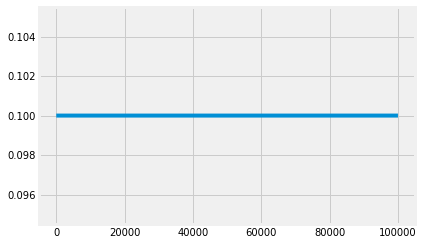

In [13]:
s = EGreedyStrategy()
plt.plot([s.epsilon for _ in range(100000)])
plt.show()

In [14]:
class NFQ():
    def __init__(self, 
                 value_model_fn, 
                 value_optimizer_fn, 
                 value_optimizer_lr,
                 training_strategy_fn,
                 evaluation_strategy_fn,
                 batch_size,
                 epochs):
        self.value_model_fn = value_model_fn
        self.value_optimizer_fn = value_optimizer_fn
        self.value_optimizer_lr = value_optimizer_lr
        self.training_strategy_fn = training_strategy_fn
        self.evaluation_strategy_fn = evaluation_strategy_fn
        self.batch_size = batch_size
        self.epochs = epochs

    def optimize_model(self, experiences):
        states, actions, rewards, next_states, is_terminals = experiences
        batch_size = len(is_terminals)
        
        max_a_q_sp = self.online_model(next_states).detach().max(1)[0].unsqueeze(1)
        target_q_s = rewards + self.gamma * max_a_q_sp * (1 - is_terminals)
        q_sa = self.online_model(states).gather(1, actions)

        td_errors = q_sa - target_q_s
        value_loss = td_errors.pow(2).mul(0.5).mean()
        self.value_optimizer.zero_grad()
        value_loss.backward()
        self.value_optimizer.step()

    def interaction_step(self, state, env):
        action = self.training_strategy.select_action(self.online_model, state)
        new_state, reward, is_terminal, _ = env.step(action)
        past_limit_enforced = hasattr(env, '_past_limit') and env._past_limit()
        is_failure = is_terminal and not past_limit_enforced

        experience = (state, action, reward, new_state, float(is_failure))
        self.experiences.append(experience)
        self.episode_reward[-1] += reward
        self.episode_timestep[-1] += 1
        self.episode_exploration[-1] += int(self.training_strategy.exploratory_action_taken)
        return new_state, is_terminal

    def train(self, make_env_fn, make_env_kargs, seed, gamma, 
              max_minutes, max_episodes, goal_mean_100_reward):
        training_start, last_debug_time = time.time(), float('-inf')

        self.make_env_fn = make_env_fn
        self.make_env_kargs = make_env_kargs
        self.seed = seed
        self.gamma = gamma
        
        env = self.make_env_fn(**self.make_env_kargs, seed=self.seed)
        torch.manual_seed(self.seed) ; np.random.seed(self.seed) ; random.seed(self.seed)
    
        nS, nA = env.observation_space.shape[0], env.action_space.n
        self.episode_timestep = []
        self.episode_reward = []
        self.episode_seconds = []
        self.evaluation_scores = []        
        self.episode_exploration = []
        
        self.online_model = self.value_model_fn(nS, nA)
        self.value_optimizer = self.value_optimizer_fn(self.online_model, 
                                                       self.value_optimizer_lr)

        self.training_strategy = training_strategy_fn()
        self.evaluation_strategy = evaluation_strategy_fn() 
        self.experiences = []

        result = np.empty((max_episodes, 5))
        result[:] = np.nan
        training_time = 0
        for episode in range(1, max_episodes + 1):
            episode_start = time.time()
            
            state, is_terminal = env.reset(), False
            self.episode_reward.append(0.0)
            self.episode_timestep.append(0.0)
            self.episode_exploration.append(0.0)

            for step in count():
                state, is_terminal = self.interaction_step(state, env)
                
                if len(self.experiences) >= self.batch_size:
                    experiences = np.array(self.experiences)
                    batches = [np.vstack(sars) for sars in experiences.T]
                    experiences = self.online_model.load(batches)
                    for _ in range(self.epochs):
                        self.optimize_model(experiences)
                    self.experiences.clear()
                
                if is_terminal:
                    break
            
            # stats
            episode_elapsed = time.time() - episode_start
            self.episode_seconds.append(episode_elapsed)
            training_time += episode_elapsed
            evaluation_score, _ = self.evaluate(self.online_model, env)
            total_step = int(np.sum(self.episode_timestep))
            self.evaluation_scores.append(evaluation_score)
            
            mean_10_reward = np.mean(self.episode_reward[-10:])
            std_10_reward = np.std(self.episode_reward[-10:])
            mean_100_reward = np.mean(self.episode_reward[-100:])
            std_100_reward = np.std(self.episode_reward[-100:])
            mean_100_eval_score = np.mean(self.evaluation_scores[-100:])
            std_100_eval_score = np.std(self.evaluation_scores[-100:])
            lst_100_exp_rat = np.array(
                self.episode_exploration[-100:])/np.array(self.episode_timestep[-100:])
            mean_100_exp_rat = np.mean(lst_100_exp_rat)
            std_100_exp_rat = np.std(lst_100_exp_rat)
            
            wallclock_elapsed = time.time() - training_start
            result[episode-1] = total_step, mean_100_reward, \
                mean_100_eval_score, training_time, wallclock_elapsed
            
            reached_debug_time = time.time() - last_debug_time >= LEAVE_PRINT_EVERY_N_SECS
            reached_max_minutes = wallclock_elapsed >= max_minutes * 60
            reached_max_episodes = episode >= max_episodes
            reached_goal_mean_reward = mean_100_eval_score >= goal_mean_100_reward
            training_is_over = reached_max_minutes or \
                               reached_max_episodes or \
                               reached_goal_mean_reward
            elapsed_str = time.strftime("%M:%S", time.gmtime(time.time() - training_start))
            debug_message = 'el {}, ep {:04}, ts {:06}, '
            debug_message += 'ar 10 {:05.1f}\u00B1{:05.1f}, '
            debug_message += '100 {:05.1f}\u00B1{:05.1f}, '
            debug_message += 'ex 100 {:02.1f}\u00B1{:02.1f}, '
            debug_message += 'ev {:05.1f}\u00B1{:05.1f}'
            debug_message = debug_message.format(
                elapsed_str, episode-1, total_step, mean_10_reward, std_10_reward, 
                mean_100_reward, std_100_reward, mean_100_exp_rat, std_100_exp_rat,
                mean_100_eval_score, std_100_eval_score)
            print(debug_message, end='\r', flush=True)
            if reached_debug_time or training_is_over:
                print(ERASE_LINE + debug_message, flush=True)
                last_debug_time = time.time()
            if training_is_over:
                if reached_max_minutes: print(u'--> reached_max_minutes \u2715')
                if reached_max_episodes: print(u'--> reached_max_episodes \u2715')
                if reached_goal_mean_reward: print(u'--> reached_goal_mean_reward \u2713')
                break
                
        final_eval_score, score_std = self.evaluate(self.online_model, env, n_episodes=100)
        wallclock_time = time.time() - training_start
        print('Training complete.')
        print('Final evaluation score {:.2f}\u00B1{:.2f} in {:.2f}s training time,'
              ' {:.2f}s wall-clock time.\n'.format(
                  final_eval_score, score_std, training_time, wallclock_time))
        env.close() ; del env
        return result, final_eval_score, training_time, wallclock_time
    
    def evaluate(self, eval_policy_model, eval_env, n_episodes=1):
        rs = []
        for _ in range(n_episodes):
            s, d = eval_env.reset(), False
            rs.append(0)
            for _ in count():
                a = self.evaluation_strategy.select_action(self.online_model, s)
                s, r, d, _ = eval_env.step(a)
                rs[-1] += r
                if d: break
        return np.mean(rs), np.std(rs)
    
    def demo(self, title='Trained {} Agent', n_episodes=10, max_n_videos=3):          
        env = self.make_env_fn(**self.make_env_kargs, monitor_mode='evaluation')
        self.evaluate(self.online_model, env, n_episodes=n_episodes)
        env.close()
        data = get_gif_html(env_videos=env.videos, 
                            title=title.format(self.__class__.__name__),
                            max_n_videos=max_n_videos)
        del env
        return HTML(data=data)

In [15]:
nfq_results = []
best_agent, best_eval_score = None, float('-inf')
for seed in [12, 34, 56, 78, 90]:
    environment_settings = {
        'env_name': 'CartPole-v1',
        'gamma': 1.00,
        'max_minutes': 20,
        'max_episodes': 10000,
        'goal_mean_100_reward': 475
    }
    
    value_model_fn = lambda nS, nA: FCQ(nS, nA, hidden_dims=(512,128))
    # value_optimizer_fn = lambda net, lr: optim.Adam(net.parameters(), lr=lr)
    value_optimizer_fn = lambda net, lr: optim.RMSprop(net.parameters(), lr=lr)
    value_optimizer_lr = 0.0005

    training_strategy_fn = lambda: EGreedyStrategy(epsilon=0.5)
    # evaluation_strategy_fn = lambda: EGreedyStrategy(epsilon=0.05)
    evaluation_strategy_fn = lambda: GreedyStrategy()

    batch_size = 1024
    epochs = 40

    env_name, gamma, max_minutes, \
    max_episodes, goal_mean_100_reward = environment_settings.values()
    agent = NFQ(value_model_fn, 
                value_optimizer_fn, 
                value_optimizer_lr,
                training_strategy_fn,
                evaluation_strategy_fn,
                batch_size,
                epochs)

    # make_env_fn, make_env_kargs = get_make_env_fn(
    #     env_name=env_name, addon_wrappers=[DiscountedCartPole,])
    make_env_fn, make_env_kargs = get_make_env_fn(env_name=env_name)
    result, final_eval_score, training_time, wallclock_time = agent.train(
        make_env_fn, make_env_kargs, seed, gamma, max_minutes, max_episodes, goal_mean_100_reward)
    nfq_results.append(result)
    if final_eval_score > best_eval_score:
        best_eval_score = final_eval_score
        best_agent = agent
nfq_results = np.array(nfq_results)
_ = BEEP()

el 00:02, ep 0000, ts 000015, ar 10 015.0±000.0, 100 015.0±000.0, ex 100 0.3±0.0, ev 009.0±000.0
el 00:22, ep 0916, ts 030445, ar 10 123.3±047.6, 100 072.5±051.3, ex 100 0.3±0.1, ev 117.1±089.2
el 00:42, ep 1098, ts 054585, ar 10 164.6±101.3, 100 152.2±091.2, ex 100 0.3±0.1, ev 333.7±103.2
el 01:02, ep 1273, ts 078204, ar 10 100.7±058.5, 100 127.0±081.5, ex 100 0.3±0.0, ev 293.9±123.5
el 01:22, ep 1427, ts 099699, ar 10 162.1±083.9, 100 140.4±089.6, ex 100 0.3±0.1, ev 370.4±114.1
el 01:42, ep 1581, ts 123553, ar 10 160.7±068.8, 100 143.9±100.0, ex 100 0.3±0.1, ev 309.2±125.2
el 02:02, ep 1710, ts 146296, ar 10 150.8±113.9, 100 175.9±111.0, ex 100 0.3±0.1, ev 414.2±092.1
el 02:22, ep 1837, ts 168252, ar 10 202.5±160.9, 100 175.9±120.9, ex 100 0.3±0.1, ev 429.1±095.0
el 02:42, ep 1973, ts 190246, ar 10 120.8±093.2, 100 158.6±117.8, ex 100 0.3±0.1, ev 391.2±109.0
el 03:02, ep 2103, ts 211538, ar 10 172.2±108.5, 100 165.2±131.6, ex 100 0.3±0.1, ev 440.2±071.7
el 03:22, ep 2231, ts 233326, 


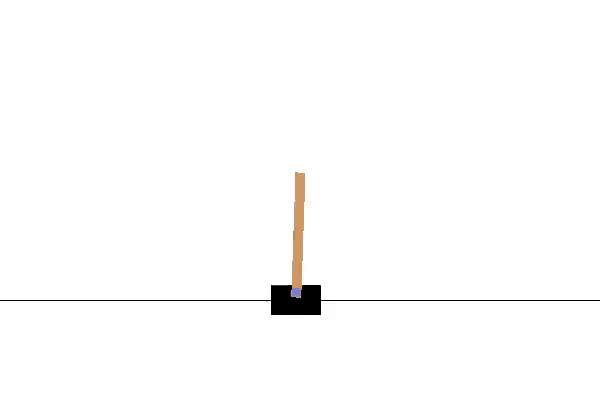
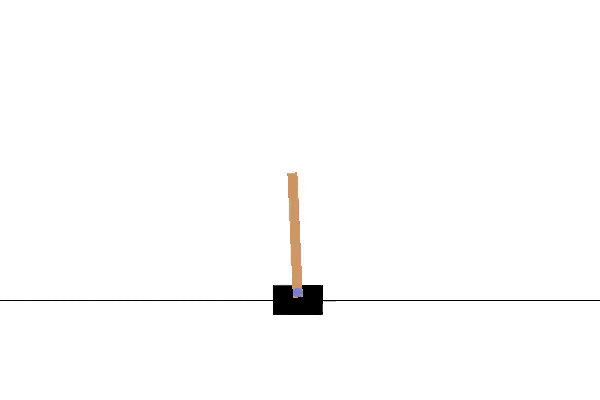
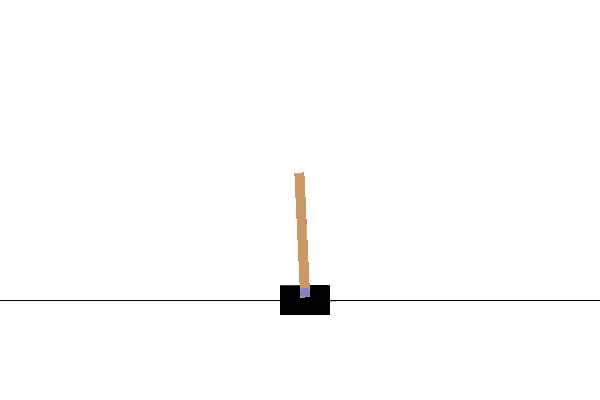

In [16]:
best_agent.demo()

In [17]:
nfq_max_t, nfq_max_r, nfq_max_s, \
    nfq_max_sec, nfq_max_rt = np.max(nfq_results, axis=0).T
nfq_min_t, nfq_min_r, nfq_min_s, \
    nfq_min_sec, nfq_min_rt = np.min(nfq_results, axis=0).T
nfq_mean_t, nfq_mean_r, nfq_mean_s, \
    nfq_mean_sec, nfq_mean_rt = np.mean(nfq_results, axis=0).T
nfq_x = np.arange(len(nfq_mean_s))

# nfq_max_t, nfq_max_r, nfq_max_s, \
#     nfq_max_sec, nfq_max_rt = np.nanmax(nfq_results, axis=0).T
# nfq_min_t, nfq_min_r, nfq_min_s, \
#     nfq_min_sec, nfq_min_rt = np.nanmin(nfq_results, axis=0).T
# nfq_mean_t, nfq_mean_r, nfq_mean_s, \
#     nfq_mean_sec, nfq_mean_rt = np.nanmean(nfq_results, axis=0).T
# nfq_x = np.arange(len(nfq_mean_s))

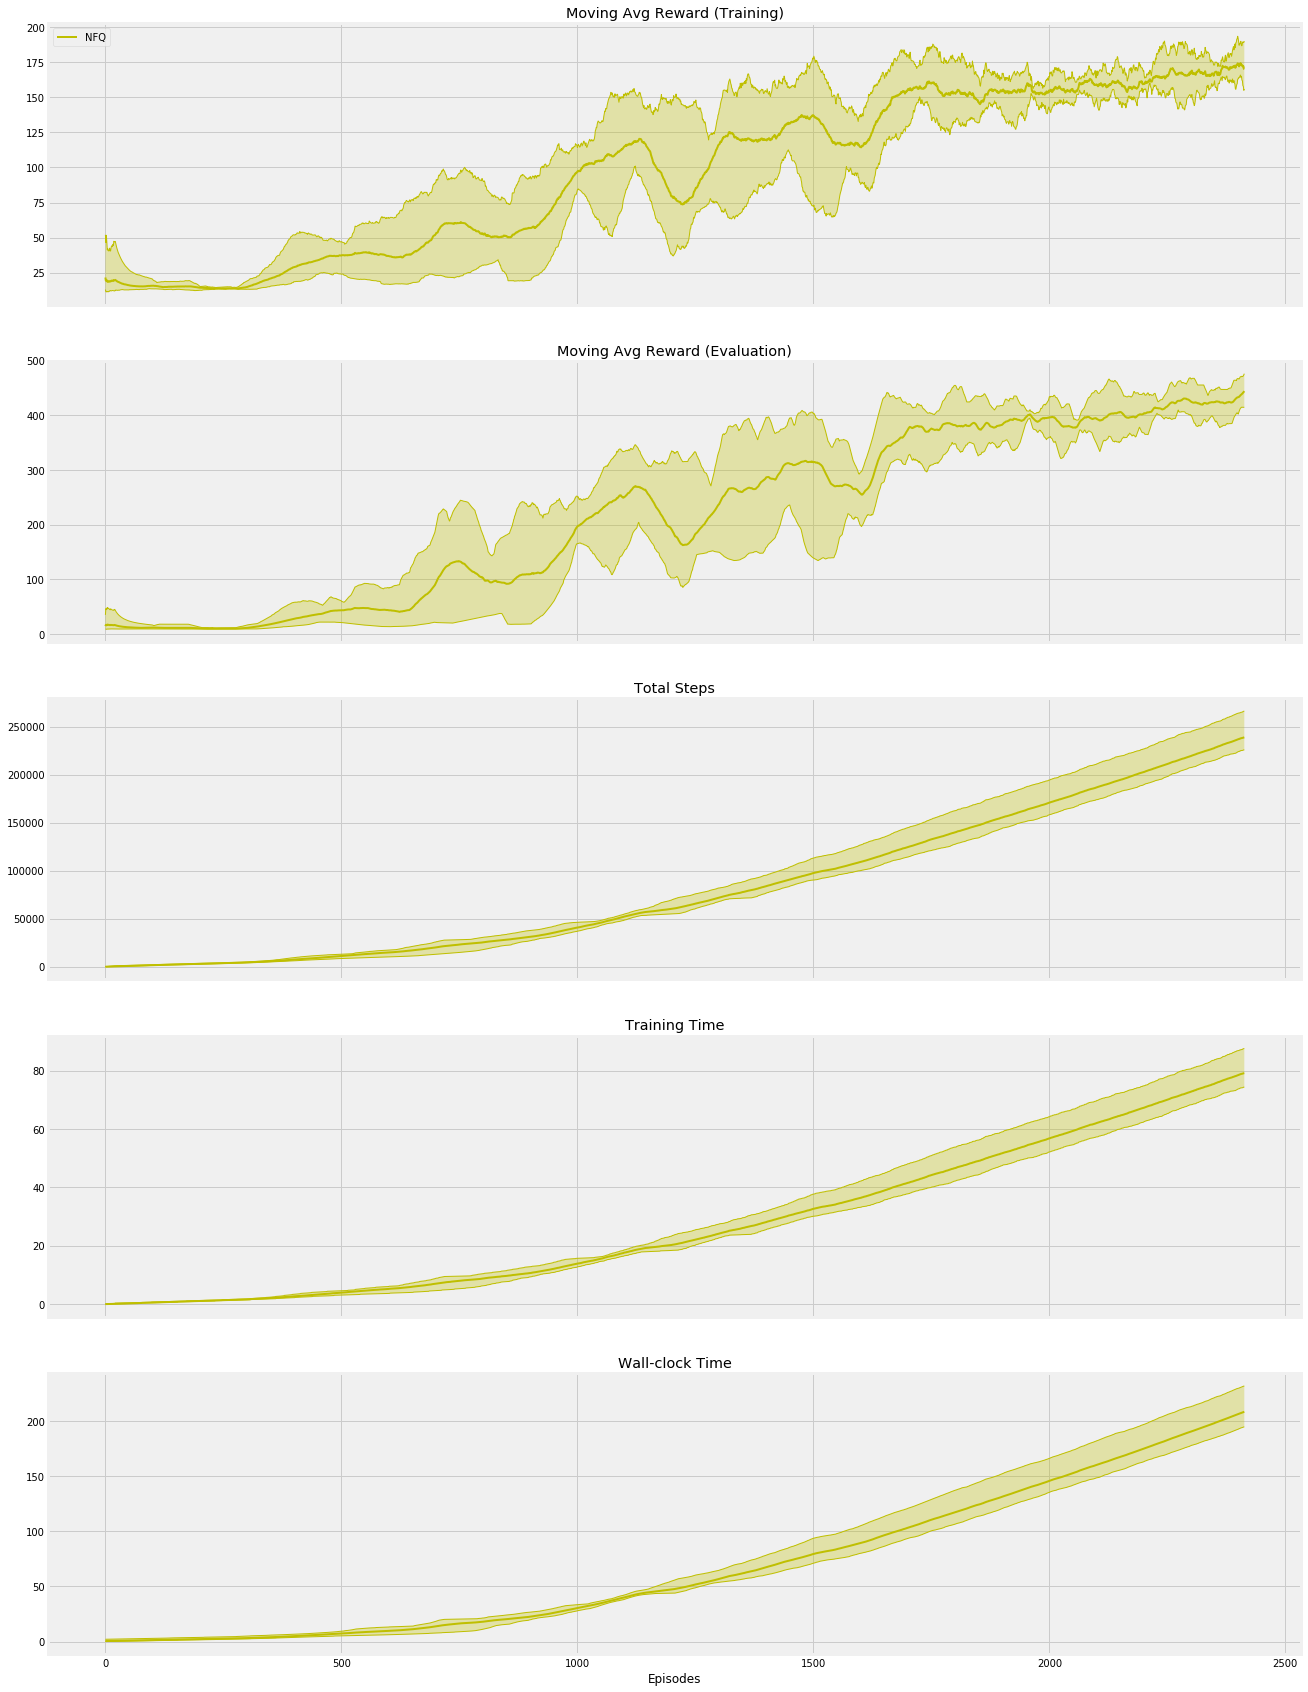

In [18]:
fig, axs = plt.subplots(5, 1, figsize=(20,30), sharey=False, sharex=True)

# NFQ
axs[0].plot(nfq_max_r, 'y', linewidth=1)
axs[0].plot(nfq_min_r, 'y', linewidth=1)
axs[0].plot(nfq_mean_r, 'y', label='NFQ', linewidth=2)
axs[0].fill_between(nfq_x, nfq_min_r, nfq_max_r, facecolor='y', alpha=0.3)

axs[1].plot(nfq_max_s, 'y', linewidth=1)
axs[1].plot(nfq_min_s, 'y', linewidth=1)
axs[1].plot(nfq_mean_s, 'y', label='NFQ', linewidth=2)
axs[1].fill_between(nfq_x, nfq_min_s, nfq_max_s, facecolor='y', alpha=0.3)

axs[2].plot(nfq_max_t, 'y', linewidth=1)
axs[2].plot(nfq_min_t, 'y', linewidth=1)
axs[2].plot(nfq_mean_t, 'y', label='NFQ', linewidth=2)
axs[2].fill_between(nfq_x, nfq_min_t, nfq_max_t, facecolor='y', alpha=0.3)

axs[3].plot(nfq_max_sec, 'y', linewidth=1)
axs[3].plot(nfq_min_sec, 'y', linewidth=1)
axs[3].plot(nfq_mean_sec, 'y', label='NFQ', linewidth=2)
axs[3].fill_between(nfq_x, nfq_min_sec, nfq_max_sec, facecolor='y', alpha=0.3)

axs[4].plot(nfq_max_rt, 'y', linewidth=1)
axs[4].plot(nfq_min_rt, 'y', linewidth=1)
axs[4].plot(nfq_mean_rt, 'y', label='NFQ', linewidth=2)
axs[4].fill_between(nfq_x, nfq_min_rt, nfq_max_rt, facecolor='y', alpha=0.3)

# ALL
axs[0].set_title('Moving Avg Reward (Training)')
axs[1].set_title('Moving Avg Reward (Evaluation)')
axs[2].set_title('Total Steps')
axs[3].set_title('Training Time')
axs[4].set_title('Wall-clock Time')
plt.xlabel('Episodes')
axs[0].legend(loc='upper left')
plt.show()

# DQN

In [19]:
class EGreedyLinearStrategy():
    def __init__(self, init_epsilon=1.0, decay_rate=0.99995, min_epsilon=0.1):
        self.epsilon = init_epsilon
        self.init_epsilon = init_epsilon
        self.decay_rate = decay_rate
        self.min_epsilon = min_epsilon
        self.exploratory_action_taken = None
    
    def _epsilon_update(self):
        self.epsilon = max(self.min_epsilon, self.decay_rate*self.epsilon)
        return self.epsilon

    def select_action(self, model, state):
        self.exploratory_action_taken = False
        with torch.no_grad():
            q_values = model(state).cpu().detach().data.numpy().squeeze()

        if np.random.rand() > self.epsilon:
            action = np.argmax(q_values)
        else: 
            action = np.random.randint(len(q_values))

        self._epsilon_update()
        self.exploratory_action_taken = action != np.argmax(q_values)
        return action

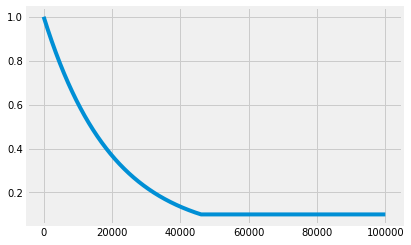

In [20]:
s = EGreedyLinearStrategy()
plt.plot([s._epsilon_update() for _ in range(100000)])
plt.show()

In [21]:
class EGreedyExpStrategy():
    def __init__(self, init_epsilon=1.0, decay_rate=0.00005, min_epsilon=0.1):
        self.t = 0
        self.init_epsilon = init_epsilon
        self.epsilon = init_epsilon
        self.decay_rate = decay_rate
        self.min_epsilon = min_epsilon
        self.exploratory_action_taken = None

    def _epsilon_update(self):
        self.epsilon = max(self.init_epsilon * np.exp(-self.decay_rate * self.t), 
                           self.min_epsilon)
        self.t += 1
        return self.epsilon

    def select_action(self, model, state):
        self.exploratory_action_taken = False
        with torch.no_grad():
            q_values = model(state).detach().cpu().data.numpy().squeeze()
            nA = len(q_values)
            argmax_q_sa = np.argmax(q_values)

        action = np.random.randint(nA)
        if np.random.rand() > self.epsilon:
            action = argmax_q_sa

        self._epsilon_update()
        self.exploratory_action_taken = action != np.argmax(q_values)
        return action

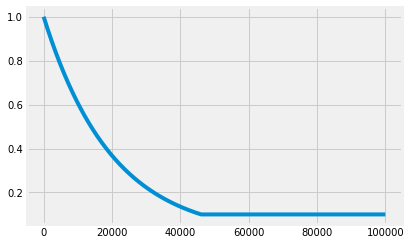

In [22]:
s = EGreedyExpStrategy()
plt.plot([s._epsilon_update() for _ in range(100000)])
plt.show()

In [23]:
class SoftMaxStrategy():
    def __init__(self, 
                 init_temp=1.0, 
                 min_temp=0.3, 
                 exploration_ratio=0.8, 
                 max_steps=60000):
        self.t = 0
        self.init_temp = init_temp
        self.exploration_ratio = exploration_ratio
        self.min_temp = min_temp
        self.max_steps = max_steps
        self.exploratory_action_taken = None
        
    def _update_temp(self):
        temp = 1 - self.t / (self.max_steps * self.exploration_ratio)
        temp = (self.init_temp - self.min_temp) * temp + self.min_temp
        temp = np.clip(temp, self.min_temp, self.init_temp)
        self.t += 1
        return temp

    def select_action(self, model, state):
        self.exploratory_action_taken = False
        temp = self._update_temp()

        with torch.no_grad():
            q_values = model(state).cpu().detach().data.numpy().squeeze()
            scaled_qs = q_values/temp
            norm_qs = scaled_qs - scaled_qs.max()            
            e = np.exp(norm_qs)
            probs = e / np.sum(e)
            assert np.isclose(probs.sum(), 1.0)

        action = np.random.choice(np.arange(len(probs)), size=1, p=probs)[0]
        self.exploratory_action_taken = action != np.argmax(q_values)
        return action

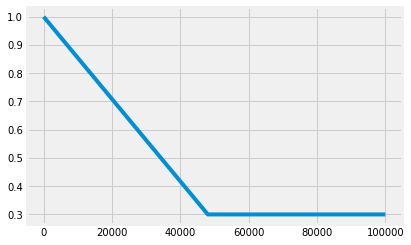

In [24]:
s = SoftMaxStrategy()
plt.plot([s._update_temp() for _ in range(100000)])
plt.show()

In [25]:
class ReplayBuffer():
    def __init__(self, 
                 max_size=10000, 
                 batch_size=64):
        self.ss_mem = np.empty(shape=(max_size), dtype=np.ndarray)
        self.as_mem = np.empty(shape=(max_size), dtype=np.ndarray)
        self.rs_mem = np.empty(shape=(max_size), dtype=np.ndarray)
        self.ps_mem = np.empty(shape=(max_size), dtype=np.ndarray)
        self.ds_mem = np.empty(shape=(max_size), dtype=np.ndarray)

        self.max_size = max_size
        self.batch_size = batch_size
        self._idx = 0
        self.size = 0
    
    def store(self, sample):
        s, a, r, p, d = sample
        self.ss_mem[self._idx] = s
        self.as_mem[self._idx] = a
        self.rs_mem[self._idx] = r
        self.ps_mem[self._idx] = p
        self.ds_mem[self._idx] = d
        
        self._idx += 1
        self._idx = self._idx % self.max_size

        self.size += 1
        self.size = min(self.size, self.max_size)

    def sample(self, batch_size=None):
        if batch_size == None:
            batch_size = self.batch_size

        idxs = np.random.choice(
            self.size, batch_size, replace=False)
        experiences = np.vstack(self.ss_mem[idxs]), \
                      np.vstack(self.as_mem[idxs]), \
                      np.vstack(self.rs_mem[idxs]), \
                      np.vstack(self.ps_mem[idxs]), \
                      np.vstack(self.ds_mem[idxs])
        return experiences

    def __len__(self):
        return self.size

In [26]:
class DQN():
    def __init__(self, 
                 reply_buffer_fn, 
                 value_model_fn, 
                 value_optimizer_fn, 
                 value_optimizer_lr,
                 training_strategy_fn,
                 evaluation_strategy_fn,
                 n_warmup_batches,
                 update_target_every_steps):
        self.replay_buffer_fn = replay_buffer_fn
        self.value_model_fn = value_model_fn
        self.value_optimizer_fn = value_optimizer_fn
        self.value_optimizer_lr = value_optimizer_lr
        self.training_strategy_fn = training_strategy_fn
        self.evaluation_strategy_fn = evaluation_strategy_fn
        self.n_warmup_batches = n_warmup_batches
        self.update_target_every_steps = update_target_every_steps

    def optimize_model(self, experiences):
        states, actions, rewards, next_states, is_terminals = experiences
        batch_size = len(is_terminals)
        
        max_a_q_sp = self.target_model(next_states).detach().max(1)[0].unsqueeze(1)
        target_q_sa = rewards + (self.gamma * max_a_q_sp * (1 - is_terminals))
        q_sa = self.online_model(states).gather(1, actions)

        td_error = q_sa - target_q_sa
        value_loss = td_error.pow(2).mul(0.5).mean()
        self.value_optimizer.zero_grad()
        value_loss.backward()
        self.value_optimizer.step()

    def interaction_step(self, state, env):
        action = self.training_strategy.select_action(self.online_model, state)
        new_state, reward, is_terminal, _ = env.step(action)
        past_limit_enforced = hasattr(env, '_past_limit') and env._past_limit()
        is_failure = is_terminal and not past_limit_enforced

        experience = (state, action, reward, new_state, float(is_failure))
        self.replay_buffer.store(experience)
        self.episode_reward[-1] += reward
        self.episode_timestep[-1] += 1
        self.episode_exploration[-1] += int(self.training_strategy.exploratory_action_taken)
        return new_state, is_terminal
    
    def update_network(self):
        for target, online in zip(self.target_model.parameters(), 
                                  self.online_model.parameters()):
            target.data.copy_(online.data)

    def train(self, make_env_fn, make_env_kargs, seed, gamma, 
              max_minutes, max_episodes, goal_mean_100_reward):
        training_start, last_debug_time = time.time(), float('-inf')

        self.make_env_fn = make_env_fn
        self.make_env_kargs = make_env_kargs
        self.seed = seed
        self.gamma = gamma
        
        env = self.make_env_fn(**self.make_env_kargs, seed=self.seed)
        torch.manual_seed(self.seed) ; np.random.seed(self.seed) ; random.seed(self.seed)
    
        nS, nA = env.observation_space.shape[0], env.action_space.n
        self.episode_timestep = []
        self.episode_reward = []
        self.episode_seconds = []
        self.evaluation_scores = []        
        self.episode_exploration = []
        
        self.target_model = self.value_model_fn(nS, nA)
        self.online_model = self.value_model_fn(nS, nA)
        self.update_network()

        self.value_optimizer = self.value_optimizer_fn(self.online_model, 
                                                       self.value_optimizer_lr)

        self.replay_buffer = self.replay_buffer_fn()
        self.training_strategy = training_strategy_fn()
        self.evaluation_strategy = evaluation_strategy_fn() 
                    
        result = np.empty((max_episodes, 5))
        result[:] = np.nan
        training_time = 0
        for episode in range(1, max_episodes + 1):
            episode_start = time.time()
            
            state, is_terminal = env.reset(), False
            self.episode_reward.append(0.0)
            self.episode_timestep.append(0.0)
            self.episode_exploration.append(0.0)

            for step in count():
                state, is_terminal = self.interaction_step(state, env)
                
                min_samples = self.replay_buffer.batch_size * self.n_warmup_batches
                if len(self.replay_buffer) > min_samples:
                    experiences = self.replay_buffer.sample()
                    experiences = self.online_model.load(experiences)
                    self.optimize_model(experiences)
                
                if np.sum(self.episode_timestep) % self.update_target_every_steps == 0:
                    self.update_network()
                
                if is_terminal:
                    break
            
            # stats
            episode_elapsed = time.time() - episode_start
            self.episode_seconds.append(episode_elapsed)
            training_time += episode_elapsed
            evaluation_score, _ = self.evaluate(self.online_model, env)
            total_step = int(np.sum(self.episode_timestep))
            self.evaluation_scores.append(evaluation_score)
            
            mean_10_reward = np.mean(self.episode_reward[-10:])
            std_10_reward = np.std(self.episode_reward[-10:])
            mean_100_reward = np.mean(self.episode_reward[-100:])
            std_100_reward = np.std(self.episode_reward[-100:])
            mean_100_eval_score = np.mean(self.evaluation_scores[-100:])
            std_100_eval_score = np.std(self.evaluation_scores[-100:])
            lst_100_exp_rat = np.array(
                self.episode_exploration[-100:])/np.array(self.episode_timestep[-100:])
            mean_100_exp_rat = np.mean(lst_100_exp_rat)
            std_100_exp_rat = np.std(lst_100_exp_rat)
            
            wallclock_elapsed = time.time() - training_start
            result[episode-1] = total_step, mean_100_reward, \
                mean_100_eval_score, training_time, wallclock_elapsed
            
            reached_debug_time = time.time() - last_debug_time >= LEAVE_PRINT_EVERY_N_SECS
            reached_max_minutes = wallclock_elapsed >= max_minutes * 60
            reached_max_episodes = episode >= max_episodes
            reached_goal_mean_reward = mean_100_eval_score >= goal_mean_100_reward
            training_is_over = reached_max_minutes or \
                               reached_max_episodes or \
                               reached_goal_mean_reward
            elapsed_str = time.strftime("%M:%S", time.gmtime(time.time() - training_start))
            debug_message = 'el {}, ep {:04}, ts {:06}, '
            debug_message += 'ar 10 {:05.1f}\u00B1{:05.1f}, '
            debug_message += '100 {:05.1f}\u00B1{:05.1f}, '
            debug_message += 'ex 100 {:02.1f}\u00B1{:02.1f}, '
            debug_message += 'ev {:05.1f}\u00B1{:05.1f}'
            debug_message = debug_message.format(
                elapsed_str, episode-1, total_step, mean_10_reward, std_10_reward, 
                mean_100_reward, std_100_reward, mean_100_exp_rat, std_100_exp_rat,
                mean_100_eval_score, std_100_eval_score)
            print(debug_message, end='\r', flush=True)
            if reached_debug_time or training_is_over:
                print(ERASE_LINE + debug_message, flush=True)
                last_debug_time = time.time()
            if training_is_over:
                if reached_max_minutes: print(u'--> reached_max_minutes \u2715')
                if reached_max_episodes: print(u'--> reached_max_episodes \u2715')
                if reached_goal_mean_reward: print(u'--> reached_goal_mean_reward \u2713')
                break
                
        final_eval_score, score_std = self.evaluate(self.online_model, env, n_episodes=100)
        wallclock_time = time.time() - training_start
        print('Training complete.')
        print('Final evaluation score {:.2f}\u00B1{:.2f} in {:.2f}s training time,'
              ' {:.2f}s wall-clock time.\n'.format(
                  final_eval_score, score_std, training_time, wallclock_time))
        env.close() ; del env
        return result, final_eval_score, training_time, wallclock_time
    
    def evaluate(self, eval_policy_model, eval_env, n_episodes=1):
        rs = []
        for _ in range(n_episodes):
            s, d = eval_env.reset(), False
            rs.append(0)
            for _ in count():
                a = self.evaluation_strategy.select_action(self.online_model, s)
                s, r, d, _ = eval_env.step(a)
                rs[-1] += r
                if d: break
        return np.mean(rs), np.std(rs)
    
    def demo(self, title='Trained {} Agent', n_episodes=10, max_n_videos=3):          
        env = self.make_env_fn(**self.make_env_kargs, monitor_mode='evaluation')
        self.evaluate(self.online_model, env, n_episodes=n_episodes)
        env.close()
        data = get_gif_html(env_videos=env.videos, 
                            title=title.format(self.__class__.__name__),
                            max_n_videos=max_n_videos)
        del env
        return HTML(data=data)

In [27]:
dqn_results = []
best_agent, best_eval_score = None, float('-inf')
for seed in [12, 34, 56, 78, 90]:
    environment_settings = {
        'env_name': 'CartPole-v1',
        'gamma': 1.00,
        'max_minutes': 20,
        'max_episodes': 10000,
        'goal_mean_100_reward': 475
    }
    
    value_model_fn = lambda nS, nA: FCQ(nS, nA, hidden_dims=(512,128))
    value_optimizer_fn = lambda net, lr: optim.RMSprop(net.parameters(), lr=lr)
    value_optimizer_lr = 0.0005

    # training_strategy_fn = lambda: EGreedyStrategy(epsilon=0.5)
    # training_strategy_fn = lambda: SoftMaxStrategy(init_temp=1.0, 
    #                                                min_temp=0.1, 
    #                                                exploration_ratio=0.8, 
    #                                                max_steps=10000)
    # training_strategy_fn = lambda: EGreedyExpStrategy(init_epsilon=1.0, 
    #                                                   decay_rate=0.00005, 
    #                                                   min_epsilon=0.1)
    training_strategy_fn = lambda: EGreedyLinearStrategy(init_epsilon=1.0, 
                                                         decay_rate=0.9999, 
                                                         min_epsilon=0.3)
    evaluation_strategy_fn = lambda: GreedyStrategy()

    replay_buffer_fn = lambda: ReplayBuffer(max_size=50000, batch_size=64)
    n_warmup_batches = 5
    update_target_every_steps = 15

    env_name, gamma, max_minutes, \
    max_episodes, goal_mean_100_reward = environment_settings.values()
    agent = DQN(replay_buffer_fn,
                value_model_fn,
                value_optimizer_fn,
                value_optimizer_lr,
                training_strategy_fn,
                evaluation_strategy_fn,
                n_warmup_batches,
                update_target_every_steps)

    make_env_fn, make_env_kargs = get_make_env_fn(env_name=env_name)
    result, final_eval_score, training_time, wallclock_time = agent.train(
        make_env_fn, make_env_kargs, seed, gamma, max_minutes, max_episodes, goal_mean_100_reward)
    dqn_results.append(result)
    if final_eval_score > best_eval_score:
        best_eval_score = final_eval_score
        best_agent = agent
dqn_results = np.array(dqn_results)
_ = BEEP()

el 00:00, ep 0000, ts 000016, ar 10 016.0±000.0, 100 016.0±000.0, ex 100 0.4±0.0, ev 019.0±000.0
el 00:20, ep 0131, ts 004906, ar 10 087.0±049.4, 100 042.1±035.3, ex 100 0.4±0.1, ev 237.6±107.9
el 00:40, ep 0183, ts 010670, ar 10 159.4±032.5, 100 083.7±057.8, ex 100 0.3±0.1, ev 214.5±059.6
el 01:00, ep 0217, ts 016545, ar 10 186.2±059.9, 100 127.0±065.1, ex 100 0.2±0.1, ev 210.2±058.8
el 01:20, ep 0234, ts 022187, ar 10 386.7±128.0, 100 170.3±106.7, ex 100 0.2±0.1, ev 252.4±109.4
el 01:42, ep 0247, ts 028087, ar 10 450.0±106.2, 100 218.2±138.9, ex 100 0.2±0.1, ev 290.3±134.3
el 02:02, ep 0259, ts 033624, ar 10 453.7±107.3, 100 263.1±152.9, ex 100 0.2±0.1, ev 320.0±146.2
el 02:23, ep 0272, ts 039084, ar 10 396.0±135.2, 100 301.3±156.0, ex 100 0.2±0.0, ev 358.2±148.7
el 02:45, ep 0284, ts 044659, ar 10 457.5±089.8, 100 338.7±155.5, ex 100 0.2±0.0, ev 391.5±144.2
el 03:06, ep 0297, ts 049851, ar 10 369.2±174.3, 100 367.9±153.4, ex 100 0.2±0.0, ev 428.6±128.0
el 03:28, ep 0309, ts 055265, 


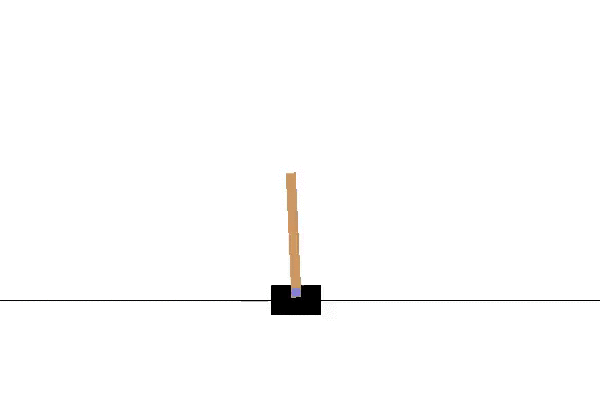
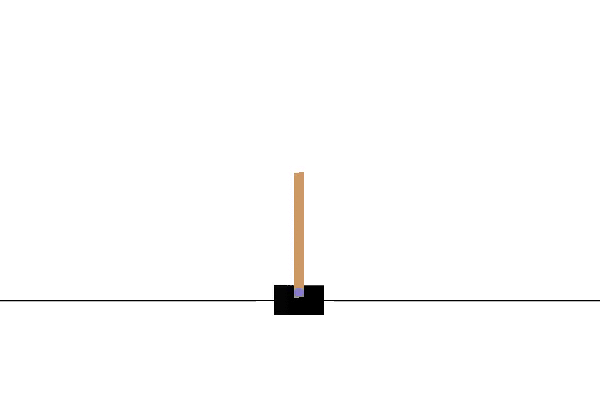
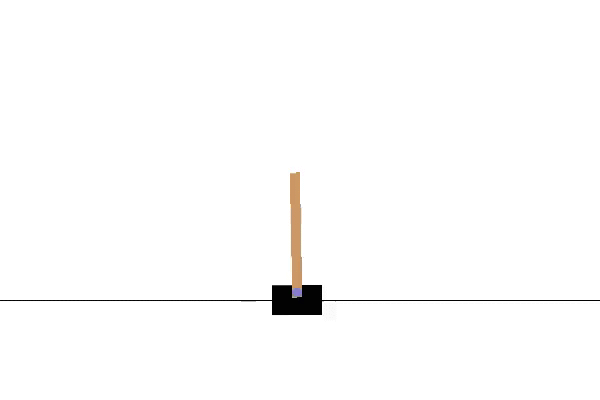

In [28]:
best_agent.demo()

In [29]:
dqn_max_t, dqn_max_r, dqn_max_s, \
    dqn_max_sec, dqn_max_rt = np.max(dqn_results, axis=0).T
dqn_min_t, dqn_min_r, dqn_min_s, \
    dqn_min_sec, dqn_min_rt = np.min(dqn_results, axis=0).T
dqn_mean_t, dqn_mean_r, dqn_mean_s, \
    dqn_mean_sec, dqn_mean_rt = np.mean(dqn_results, axis=0).T
dqn_x = np.arange(np.max((len(dqn_mean_s), len(nfq_mean_s))))

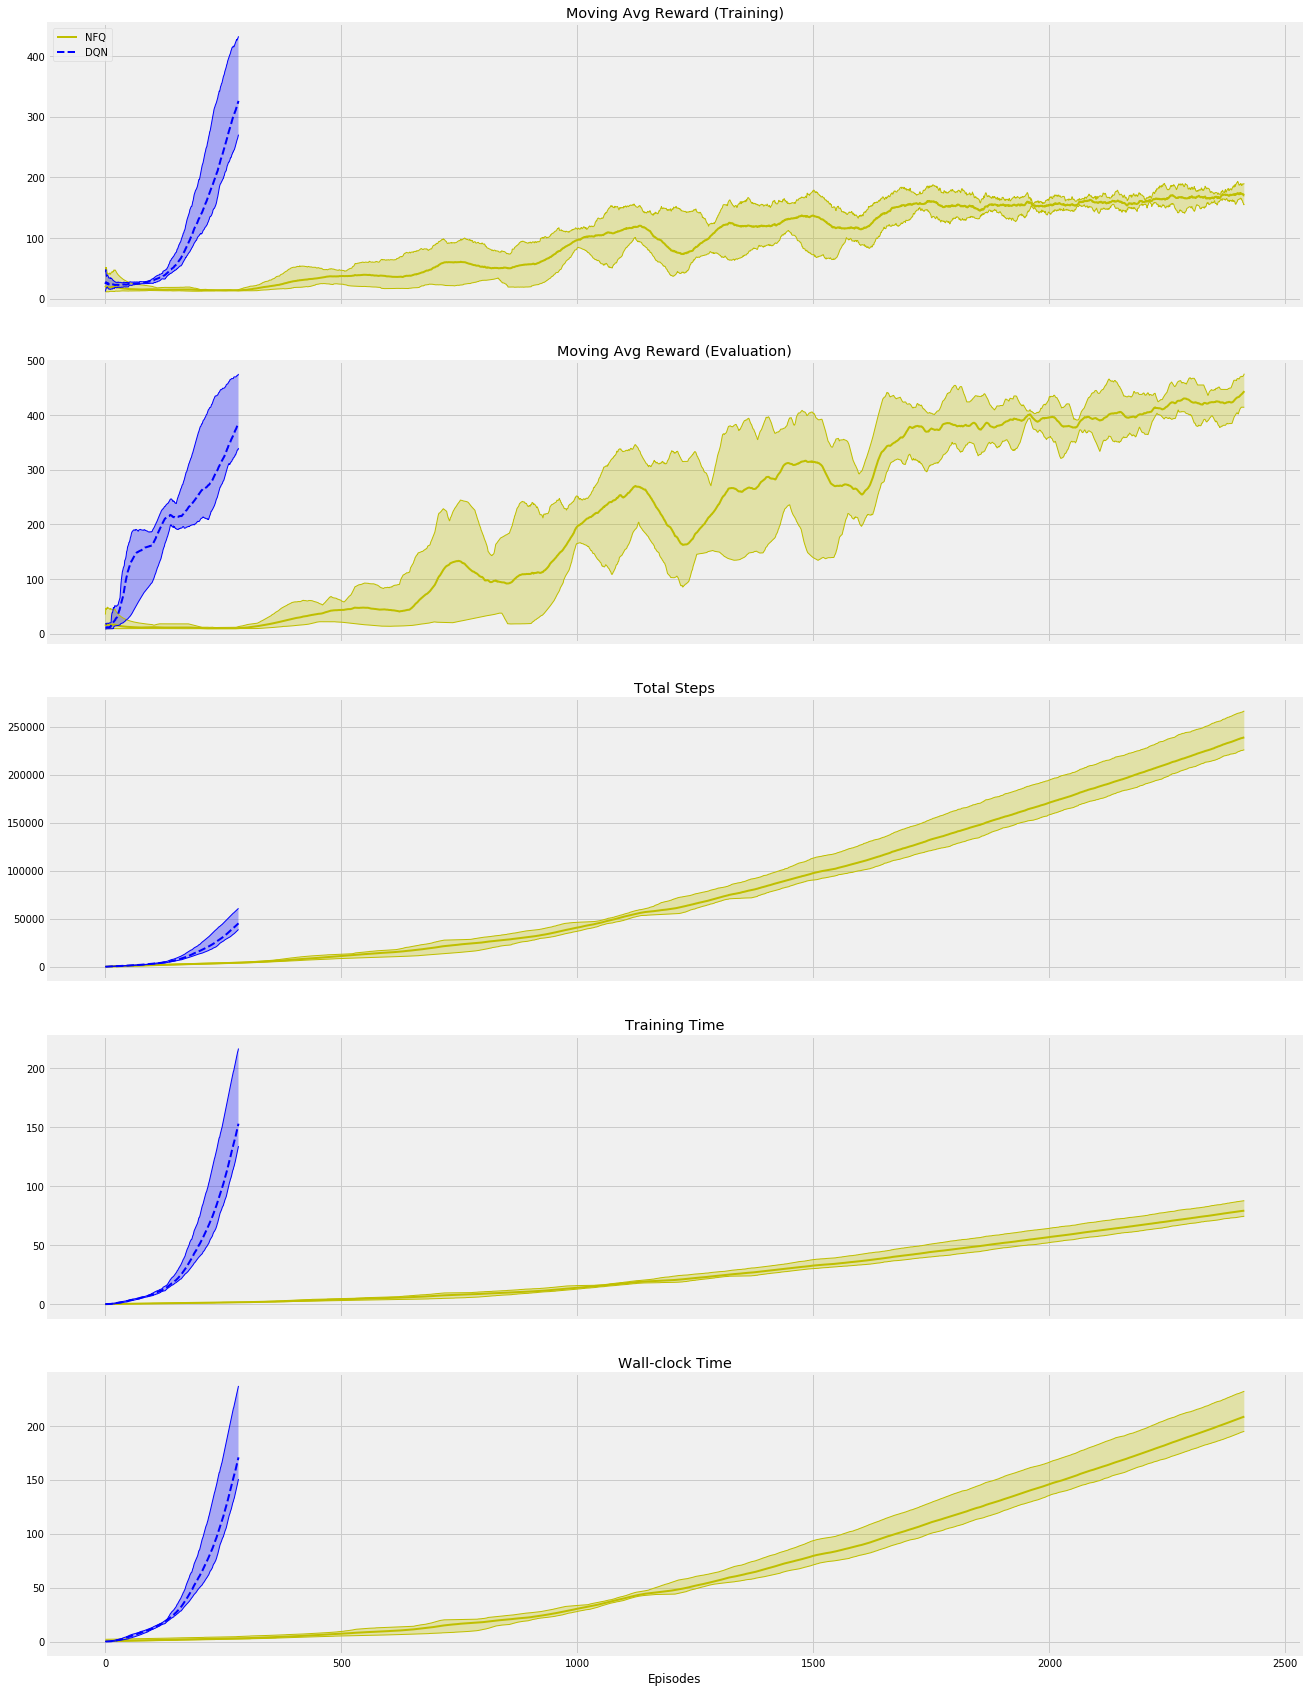

In [30]:
fig, axs = plt.subplots(5, 1, figsize=(20,30), sharey=False, sharex=True)

# NFQ
axs[0].plot(nfq_max_r, 'y', linewidth=1)
axs[0].plot(nfq_min_r, 'y', linewidth=1)
axs[0].plot(nfq_mean_r, 'y', label='NFQ', linewidth=2)
axs[0].fill_between(nfq_x, nfq_min_r, nfq_max_r, facecolor='y', alpha=0.3)

axs[1].plot(nfq_max_s, 'y', linewidth=1)
axs[1].plot(nfq_min_s, 'y', linewidth=1)
axs[1].plot(nfq_mean_s, 'y', label='NFQ', linewidth=2)
axs[1].fill_between(nfq_x, nfq_min_s, nfq_max_s, facecolor='y', alpha=0.3)

axs[2].plot(nfq_max_t, 'y', linewidth=1)
axs[2].plot(nfq_min_t, 'y', linewidth=1)
axs[2].plot(nfq_mean_t, 'y', label='NFQ', linewidth=2)
axs[2].fill_between(nfq_x, nfq_min_t, nfq_max_t, facecolor='y', alpha=0.3)

axs[3].plot(nfq_max_sec, 'y', linewidth=1)
axs[3].plot(nfq_min_sec, 'y', linewidth=1)
axs[3].plot(nfq_mean_sec, 'y', label='NFQ', linewidth=2)
axs[3].fill_between(nfq_x, nfq_min_sec, nfq_max_sec, facecolor='y', alpha=0.3)

axs[4].plot(nfq_max_rt, 'y', linewidth=1)
axs[4].plot(nfq_min_rt, 'y', linewidth=1)
axs[4].plot(nfq_mean_rt, 'y', label='NFQ', linewidth=2)
axs[4].fill_between(nfq_x, nfq_min_rt, nfq_max_rt, facecolor='y', alpha=0.3)

# DQN
axs[0].plot(dqn_max_r, 'b', linewidth=1)
axs[0].plot(dqn_min_r, 'b', linewidth=1)
axs[0].plot(dqn_mean_r, 'b--', label='DQN', linewidth=2)
axs[0].fill_between(dqn_x, dqn_min_r, dqn_max_r, facecolor='b', alpha=0.3)

axs[1].plot(dqn_max_s, 'b', linewidth=1)
axs[1].plot(dqn_min_s, 'b', linewidth=1)
axs[1].plot(dqn_mean_s, 'b--', label='DQN', linewidth=2)
axs[1].fill_between(dqn_x, dqn_min_s, dqn_max_s, facecolor='b', alpha=0.3)

axs[2].plot(dqn_max_t, 'b', linewidth=1)
axs[2].plot(dqn_min_t, 'b', linewidth=1)
axs[2].plot(dqn_mean_t, 'b--', label='DQN', linewidth=2)
axs[2].fill_between(dqn_x, dqn_min_t, dqn_max_t, facecolor='b', alpha=0.3)

axs[3].plot(dqn_max_sec, 'b', linewidth=1)
axs[3].plot(dqn_min_sec, 'b', linewidth=1)
axs[3].plot(dqn_mean_sec, 'b--', label='DQN', linewidth=2)
axs[3].fill_between(dqn_x, dqn_min_sec, dqn_max_sec, facecolor='b', alpha=0.3)

axs[4].plot(dqn_max_rt, 'b', linewidth=1)
axs[4].plot(dqn_min_rt, 'b', linewidth=1)
axs[4].plot(dqn_mean_rt, 'b--', label='DQN', linewidth=2)
axs[4].fill_between(dqn_x, dqn_min_rt, dqn_max_rt, facecolor='b', alpha=0.3)

# ALL
axs[0].set_title('Moving Avg Reward (Training)')
axs[1].set_title('Moving Avg Reward (Evaluation)')
axs[2].set_title('Total Steps')
axs[3].set_title('Training Time')
axs[4].set_title('Wall-clock Time')
plt.xlabel('Episodes')
axs[0].legend(loc='upper left')
plt.show()

# Double DQN

In [31]:
class DDQN():
    def __init__(self, 
                 reply_buffer_fn, 
                 value_model_fn, 
                 value_optimizer_fn, 
                 value_optimizer_lr,
                 max_gradient_norm,
                 training_strategy_fn,
                 evaluation_strategy_fn,
                 n_warmup_batches,
                 update_target_every_steps):
        self.replay_buffer_fn = replay_buffer_fn
        self.value_model_fn = value_model_fn
        self.value_optimizer_fn = value_optimizer_fn
        self.value_optimizer_lr = value_optimizer_lr
        self.max_gradient_norm = max_gradient_norm
        self.training_strategy_fn = training_strategy_fn
        self.evaluation_strategy_fn = evaluation_strategy_fn
        self.n_warmup_batches = n_warmup_batches
        self.update_target_every_steps = update_target_every_steps

    def optimize_model(self, experiences):
        states, actions, rewards, next_states, is_terminals = experiences
        batch_size = len(is_terminals)
        
        # argmax_a_q_sp = self.target_model(next_states).max(1)[1]
        argmax_a_q_sp = self.online_model(next_states).max(1)[1]
        q_sp = self.target_model(next_states).detach()
        max_a_q_sp = q_sp[
            np.arange(batch_size), argmax_a_q_sp].unsqueeze(1)
        target_q_sa = rewards + (self.gamma * max_a_q_sp * (1 - is_terminals))
        q_sa = self.online_model(states).gather(1, actions)

        td_error = q_sa - target_q_sa
        value_loss = td_error.pow(2).mul(0.5).mean()
        self.value_optimizer.zero_grad()
        value_loss.backward()        
        torch.nn.utils.clip_grad_norm_(self.online_model.parameters(), 
                                       self.max_gradient_norm)
        self.value_optimizer.step()

    def interaction_step(self, state, env):
        action = self.training_strategy.select_action(self.online_model, state)
        new_state, reward, is_terminal, _ = env.step(action)
        past_limit_enforced = hasattr(env, '_past_limit') and env._past_limit()
        is_failure = is_terminal and not past_limit_enforced

        experience = (state, action, reward, new_state, float(is_failure))
        self.replay_buffer.store(experience)
        self.episode_reward[-1] += reward
        self.episode_timestep[-1] += 1
        self.episode_exploration[-1] += int(self.training_strategy.exploratory_action_taken)
        return new_state, is_terminal
    
    def update_network(self):
        for target, online in zip(self.target_model.parameters(), 
                                  self.online_model.parameters()):
            target.data.copy_(online.data)

    def train(self, make_env_fn, make_env_kargs, seed, gamma, 
              max_minutes, max_episodes, goal_mean_100_reward):
        training_start, last_debug_time = time.time(), float('-inf')

        self.make_env_fn = make_env_fn
        self.make_env_kargs = make_env_kargs
        self.seed = seed
        self.gamma = gamma
        
        env = self.make_env_fn(**self.make_env_kargs, seed=self.seed)
        torch.manual_seed(self.seed) ; np.random.seed(self.seed) ; random.seed(self.seed)
    
        nS, nA = env.observation_space.shape[0], env.action_space.n
        self.episode_timestep = []
        self.episode_reward = []
        self.episode_seconds = []
        self.evaluation_scores = []        
        self.episode_exploration = []
        
        self.target_model = self.value_model_fn(nS, nA)
        self.online_model = self.value_model_fn(nS, nA)
        self.update_network()

        self.value_optimizer = self.value_optimizer_fn(self.online_model, 
                                                       self.value_optimizer_lr)

        self.replay_buffer = self.replay_buffer_fn()
        self.training_strategy = training_strategy_fn()
        self.evaluation_strategy = evaluation_strategy_fn() 
                    
        result = np.empty((max_episodes, 5))
        result[:] = np.nan
        training_time = 0
        for episode in range(1, max_episodes + 1):
            episode_start = time.time()
            
            state, is_terminal = env.reset(), False
            self.episode_reward.append(0.0)
            self.episode_timestep.append(0.0)
            self.episode_exploration.append(0.0)

            for step in count():
                state, is_terminal = self.interaction_step(state, env)
                
                min_samples = self.replay_buffer.batch_size * self.n_warmup_batches
                if len(self.replay_buffer) > min_samples:
                    experiences = self.replay_buffer.sample()
                    experiences = self.online_model.load(experiences)
                    self.optimize_model(experiences)
                
                if np.sum(self.episode_timestep) % self.update_target_every_steps == 0:
                    self.update_network()

                if is_terminal:
                    break
            
            # stats
            episode_elapsed = time.time() - episode_start
            self.episode_seconds.append(episode_elapsed)
            training_time += episode_elapsed
            evaluation_score, _ = self.evaluate(self.online_model, env)
            total_step = int(np.sum(self.episode_timestep))
            self.evaluation_scores.append(evaluation_score)
            
            mean_10_reward = np.mean(self.episode_reward[-10:])
            std_10_reward = np.std(self.episode_reward[-10:])
            mean_100_reward = np.mean(self.episode_reward[-100:])
            std_100_reward = np.std(self.episode_reward[-100:])
            mean_100_eval_score = np.mean(self.evaluation_scores[-100:])
            std_100_eval_score = np.std(self.evaluation_scores[-100:])
            lst_100_exp_rat = np.array(
                self.episode_exploration[-100:])/np.array(self.episode_timestep[-100:])
            mean_100_exp_rat = np.mean(lst_100_exp_rat)
            std_100_exp_rat = np.std(lst_100_exp_rat)
            
            wallclock_elapsed = time.time() - training_start
            result[episode-1] = total_step, mean_100_reward, \
                mean_100_eval_score, training_time, wallclock_elapsed
            
            reached_debug_time = time.time() - last_debug_time >= LEAVE_PRINT_EVERY_N_SECS
            reached_max_minutes = wallclock_elapsed >= max_minutes * 60
            reached_max_episodes = episode >= max_episodes
            reached_goal_mean_reward = mean_100_eval_score >= goal_mean_100_reward
            training_is_over = reached_max_minutes or \
                               reached_max_episodes or \
                               reached_goal_mean_reward
            elapsed_str = time.strftime("%M:%S", time.gmtime(time.time() - training_start))
            debug_message = 'el {}, ep {:04}, ts {:06}, '
            debug_message += 'ar 10 {:05.1f}\u00B1{:05.1f}, '
            debug_message += '100 {:05.1f}\u00B1{:05.1f}, '
            debug_message += 'ex 100 {:02.1f}\u00B1{:02.1f}, '
            debug_message += 'ev {:05.1f}\u00B1{:05.1f}'
            debug_message = debug_message.format(
                elapsed_str, episode-1, total_step, mean_10_reward, std_10_reward, 
                mean_100_reward, std_100_reward, mean_100_exp_rat, std_100_exp_rat,
                mean_100_eval_score, std_100_eval_score)
            print(debug_message, end='\r', flush=True)
            if reached_debug_time or training_is_over:
                print(ERASE_LINE + debug_message, flush=True)
                last_debug_time = time.time()
            if training_is_over:
                if reached_max_minutes: print(u'--> reached_max_minutes \u2715')
                if reached_max_episodes: print(u'--> reached_max_episodes \u2715')
                if reached_goal_mean_reward: print(u'--> reached_goal_mean_reward \u2713')
                break
                
        final_eval_score, score_std = self.evaluate(self.online_model, env, n_episodes=100)
        wallclock_time = time.time() - training_start
        print('Training complete.')
        print('Final evaluation score {:.2f}\u00B1{:.2f} in {:.2f}s training time,'
              ' {:.2f}s wall-clock time.\n'.format(
                  final_eval_score, score_std, training_time, wallclock_time))
        env.close() ; del env
        return result, final_eval_score, training_time, wallclock_time
    
    def evaluate(self, eval_policy_model, eval_env, n_episodes=1):
        rs = []
        for _ in range(n_episodes):
            s, d = eval_env.reset(), False
            rs.append(0)
            for _ in count():
                a = self.evaluation_strategy.select_action(self.online_model, s)
                s, r, d, _ = eval_env.step(a)
                rs[-1] += r
                if d: break
        return np.mean(rs), np.std(rs)
    
    def demo(self, title='Trained {} Agent', n_episodes=10, max_n_videos=3):          
        env = self.make_env_fn(**self.make_env_kargs, monitor_mode='evaluation')
        self.evaluate(self.online_model, env, n_episodes=n_episodes)
        env.close()
        data = get_gif_html(env_videos=env.videos, 
                            title=title.format(self.__class__.__name__),
                            max_n_videos=max_n_videos)
        del env
        return HTML(data=data)

In [32]:
ddqn_results = []
best_agent, best_eval_score = None, float('-inf')
for seed in [12, 34, 56, 78, 90]:
    environment_settings = {
        'env_name': 'CartPole-v1',
        'gamma': 1.00,
        'max_minutes': 20,
        'max_episodes': 10000,
        'goal_mean_100_reward': 475
    }

    value_model_fn = lambda nS, nA: FCQ(nS, nA, hidden_dims=(512,128))
    value_optimizer_fn = lambda net, lr: optim.RMSprop(net.parameters(), lr=lr)
    value_optimizer_lr = 0.0007
    max_gradient_norm = float('inf')

    training_strategy_fn = lambda: EGreedyLinearStrategy(init_epsilon=1.0, 
                                                         decay_rate=0.9999, 
                                                         min_epsilon=0.3)
    evaluation_strategy_fn = lambda: GreedyStrategy()

    replay_buffer_fn = lambda: ReplayBuffer(max_size=50000, batch_size=64)
    n_warmup_batches = 5
    update_target_every_steps = 15

    env_name, gamma, max_minutes, \
    max_episodes, goal_mean_100_reward = environment_settings.values()
    agent = DDQN(replay_buffer_fn, 
                 value_model_fn, 
                 value_optimizer_fn, 
                 value_optimizer_lr,
                 max_gradient_norm,
                 training_strategy_fn,
                 evaluation_strategy_fn,
                 n_warmup_batches,
                 update_target_every_steps)

    make_env_fn, make_env_kargs = get_make_env_fn(env_name=env_name)
    result, final_eval_score, training_time, wallclock_time = agent.train(
        make_env_fn, make_env_kargs, seed, gamma, max_minutes, max_episodes, goal_mean_100_reward)
    ddqn_results.append(result)
    if final_eval_score > best_eval_score:
        best_eval_score = final_eval_score
        best_agent = agent
ddqn_results = np.array(ddqn_results)
_ = BEEP()

el 00:00, ep 0000, ts 000016, ar 10 016.0±000.0, 100 016.0±000.0, ex 100 0.4±0.0, ev 019.0±000.0
el 00:20, ep 0128, ts 004042, ar 10 050.6±028.2, 100 034.6±021.2, ex 100 0.5±0.1, ev 229.9±113.8
el 00:40, ep 0170, ts 008781, ar 10 156.5±071.6, 100 071.4±058.8, ex 100 0.4±0.1, ev 218.2±073.4
el 01:01, ep 0195, ts 013673, ar 10 180.5±051.4, 100 111.6±081.5, ex 100 0.3±0.1, ev 236.4±077.8
el 01:21, ep 0218, ts 018424, ar 10 217.9±098.5, 100 148.9±087.5, ex 100 0.2±0.1, ev 249.8±076.7
el 01:42, ep 0241, ts 023115, ar 10 179.6±082.1, 100 178.2±083.5, ex 100 0.2±0.1, ev 274.9±087.7
el 02:03, ep 0253, ts 027807, ar 10 414.3±105.5, 100 213.6±106.9, ex 100 0.2±0.1, ev 299.3±111.1
el 02:24, ep 0264, ts 032930, ar 10 462.3±097.0, 100 251.7±127.6, ex 100 0.2±0.0, ev 330.0±122.1
el 02:46, ep 0274, ts 037922, ar 10 499.2±002.4, 100 285.1±141.3, ex 100 0.2±0.0, ev 349.0±127.4
el 03:08, ep 0286, ts 042795, ar 10 387.3±175.6, 100 307.4±153.1, ex 100 0.2±0.0, ev 376.3±129.1
el 03:29, ep 0295, ts 047295, 

el 04:37, ep 0329, ts 060659, ar 10 349.7±111.9, 100 408.7±132.5, ex 100 0.2±0.0, ev 477.9±065.1
--> reached_goal_mean_reward ✓
Training complete.
Final evaluation score 486.17±60.30 in 254.55s training time, 288.41s wall-clock time.




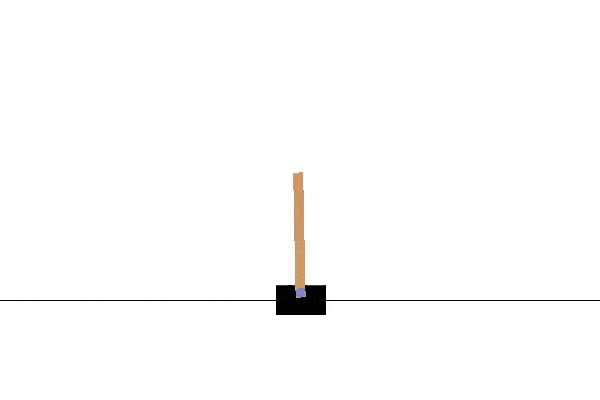
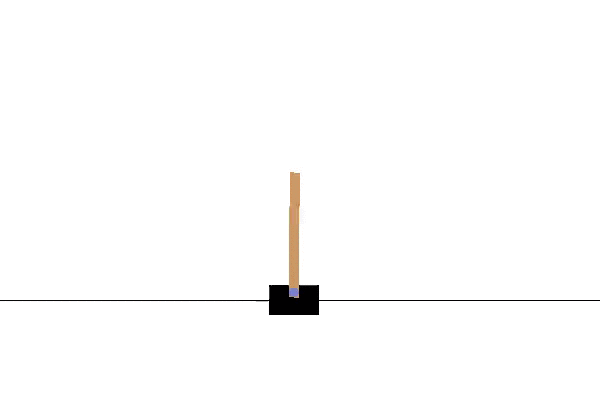
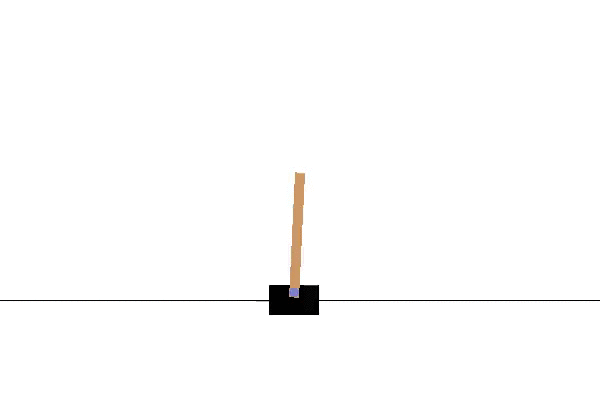

In [33]:
best_agent.demo()

In [34]:
ddqn_max_t, ddqn_max_r, ddqn_max_s, ddqn_max_sec, ddqn_max_rt = np.max(ddqn_results, axis=0).T
ddqn_min_t, ddqn_min_r, ddqn_min_s, ddqn_min_sec, ddqn_min_rt = np.min(ddqn_results, axis=0).T
ddqn_mean_t, ddqn_mean_r, ddqn_mean_s, ddqn_mean_sec, ddqn_mean_rt = np.mean(ddqn_results, axis=0).T
ddqn_x = np.arange(np.max((len(ddqn_mean_s), len(dqn_mean_s), len(nfq_mean_s))))

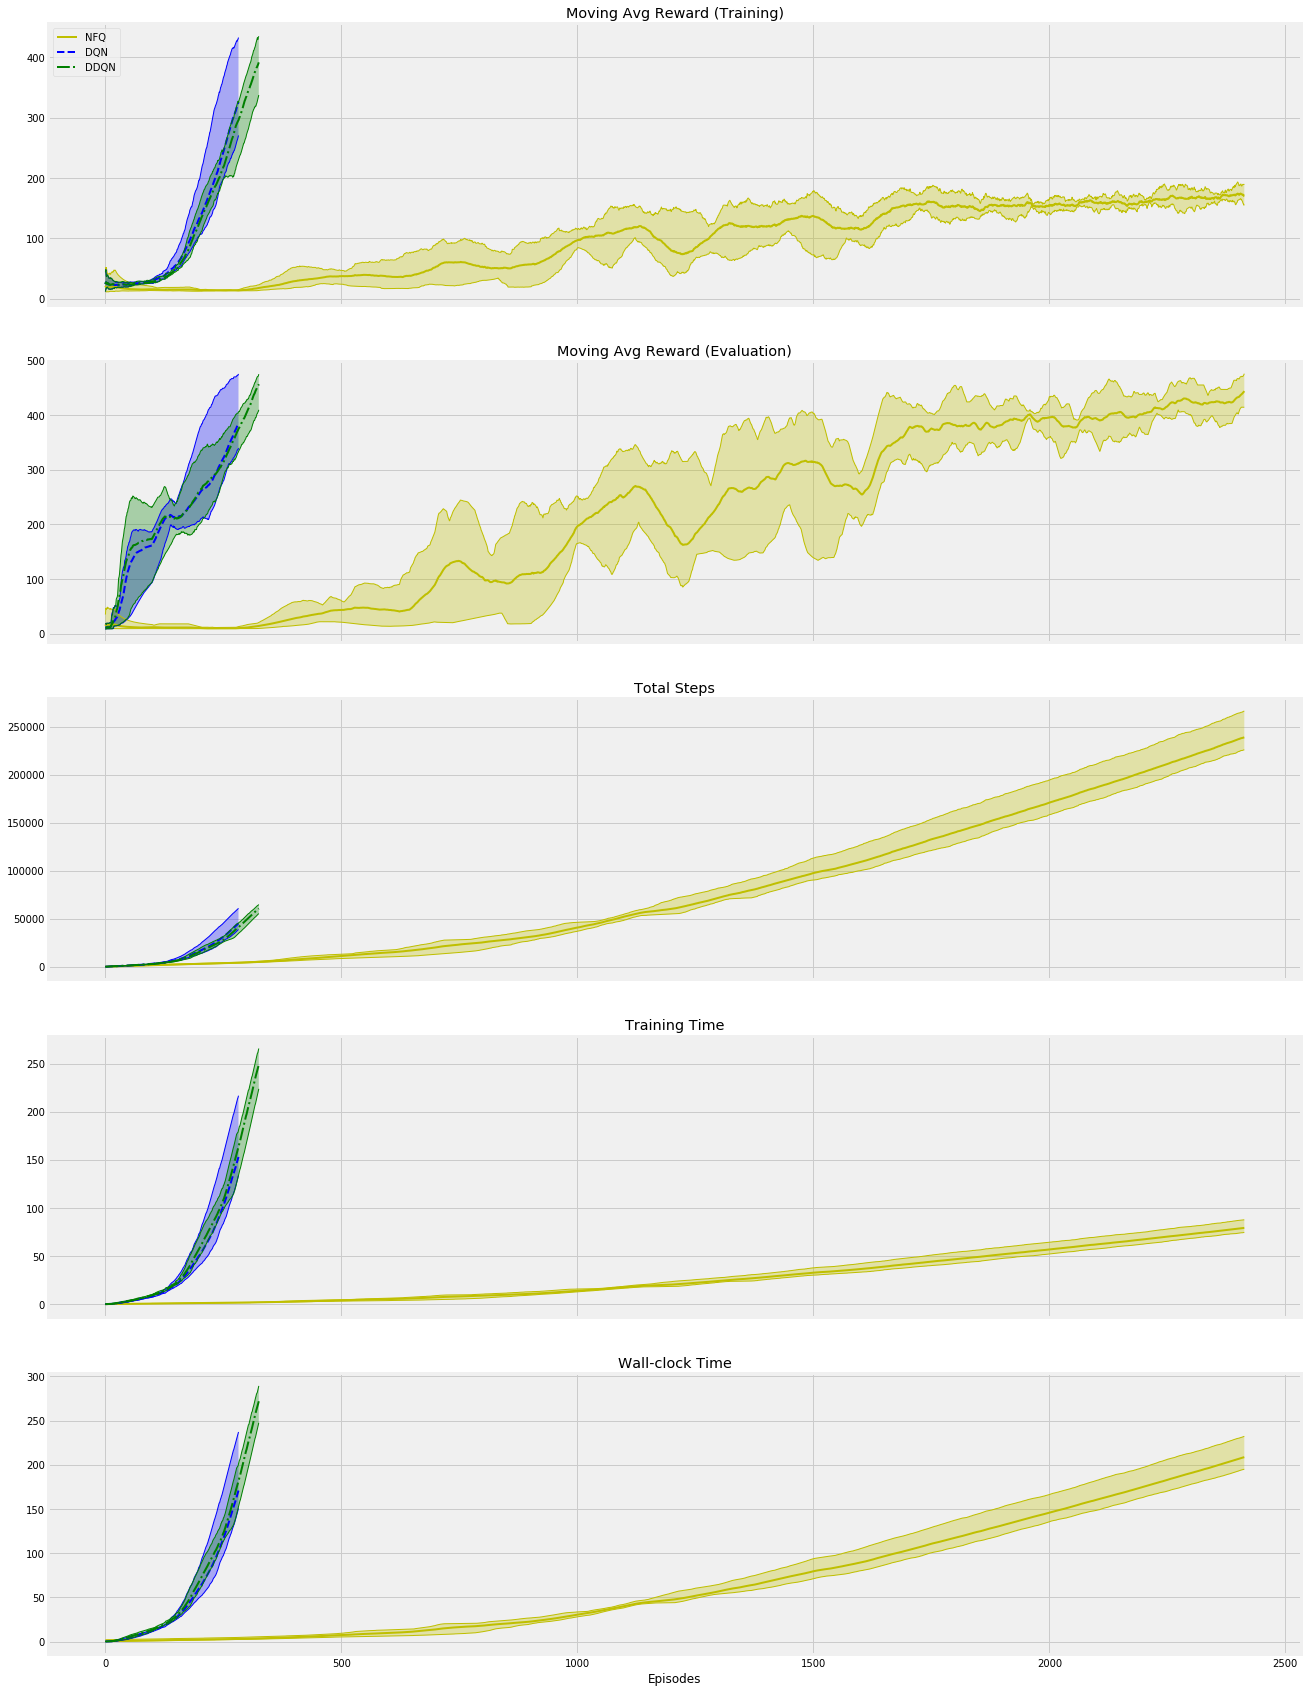

In [35]:
fig, axs = plt.subplots(5, 1, figsize=(20,30), sharey=False, sharex=True)

# NFQ
axs[0].plot(nfq_max_r, 'y', linewidth=1)
axs[0].plot(nfq_min_r, 'y', linewidth=1)
axs[0].plot(nfq_mean_r, 'y', label='NFQ', linewidth=2)
axs[0].fill_between(nfq_x, nfq_min_r, nfq_max_r, facecolor='y', alpha=0.3)

axs[1].plot(nfq_max_s, 'y', linewidth=1)
axs[1].plot(nfq_min_s, 'y', linewidth=1)
axs[1].plot(nfq_mean_s, 'y', label='NFQ', linewidth=2)
axs[1].fill_between(nfq_x, nfq_min_s, nfq_max_s, facecolor='y', alpha=0.3)

axs[2].plot(nfq_max_t, 'y', linewidth=1)
axs[2].plot(nfq_min_t, 'y', linewidth=1)
axs[2].plot(nfq_mean_t, 'y', label='NFQ', linewidth=2)
axs[2].fill_between(nfq_x, nfq_min_t, nfq_max_t, facecolor='y', alpha=0.3)

axs[3].plot(nfq_max_sec, 'y', linewidth=1)
axs[3].plot(nfq_min_sec, 'y', linewidth=1)
axs[3].plot(nfq_mean_sec, 'y', label='NFQ', linewidth=2)
axs[3].fill_between(nfq_x, nfq_min_sec, nfq_max_sec, facecolor='y', alpha=0.3)

axs[4].plot(nfq_max_rt, 'y', linewidth=1)
axs[4].plot(nfq_min_rt, 'y', linewidth=1)
axs[4].plot(nfq_mean_rt, 'y', label='NFQ', linewidth=2)
axs[4].fill_between(nfq_x, nfq_min_rt, nfq_max_rt, facecolor='y', alpha=0.3)

# DQN
axs[0].plot(dqn_max_r, 'b', linewidth=1)
axs[0].plot(dqn_min_r, 'b', linewidth=1)
axs[0].plot(dqn_mean_r, 'b--', label='DQN', linewidth=2)
axs[0].fill_between(dqn_x, dqn_min_r, dqn_max_r, facecolor='b', alpha=0.3)

axs[1].plot(dqn_max_s, 'b', linewidth=1)
axs[1].plot(dqn_min_s, 'b', linewidth=1)
axs[1].plot(dqn_mean_s, 'b--', label='DQN', linewidth=2)
axs[1].fill_between(dqn_x, dqn_min_s, dqn_max_s, facecolor='b', alpha=0.3)

axs[2].plot(dqn_max_t, 'b', linewidth=1)
axs[2].plot(dqn_min_t, 'b', linewidth=1)
axs[2].plot(dqn_mean_t, 'b--', label='DQN', linewidth=2)
axs[2].fill_between(dqn_x, dqn_min_t, dqn_max_t, facecolor='b', alpha=0.3)

axs[3].plot(dqn_max_sec, 'b', linewidth=1)
axs[3].plot(dqn_min_sec, 'b', linewidth=1)
axs[3].plot(dqn_mean_sec, 'b--', label='DQN', linewidth=2)
axs[3].fill_between(dqn_x, dqn_min_sec, dqn_max_sec, facecolor='b', alpha=0.3)

axs[4].plot(dqn_max_rt, 'b', linewidth=1)
axs[4].plot(dqn_min_rt, 'b', linewidth=1)
axs[4].plot(dqn_mean_rt, 'b--', label='DQN', linewidth=2)
axs[4].fill_between(dqn_x, dqn_min_rt, dqn_max_rt, facecolor='b', alpha=0.3)

# DDQN
axs[0].plot(ddqn_max_r, 'g', linewidth=1)
axs[0].plot(ddqn_min_r, 'g', linewidth=1)
axs[0].plot(ddqn_mean_r, 'g-.', label='DDQN', linewidth=2)
axs[0].fill_between(ddqn_x, ddqn_min_r, ddqn_max_r, facecolor='g', alpha=0.3)

axs[1].plot(ddqn_max_s, 'g', linewidth=1)
axs[1].plot(ddqn_min_s, 'g', linewidth=1)
axs[1].plot(ddqn_mean_s, 'g-.', label='DDQN', linewidth=2)
axs[1].fill_between(ddqn_x, ddqn_min_s, ddqn_max_s, facecolor='g', alpha=0.3)

axs[2].plot(ddqn_max_t, 'g', linewidth=1)
axs[2].plot(ddqn_min_t, 'g', linewidth=1)
axs[2].plot(ddqn_mean_t, 'g-.', label='DDQN', linewidth=2)
axs[2].fill_between(ddqn_x, ddqn_min_t, ddqn_max_t, facecolor='g', alpha=0.3)

axs[3].plot(ddqn_max_sec, 'g', linewidth=1)
axs[3].plot(ddqn_min_sec, 'g', linewidth=1)
axs[3].plot(ddqn_mean_sec, 'g-.', label='DDQN', linewidth=2)
axs[3].fill_between(ddqn_x, ddqn_min_sec, ddqn_max_sec, facecolor='g', alpha=0.3)

axs[4].plot(ddqn_max_rt, 'g', linewidth=1)
axs[4].plot(ddqn_min_rt, 'g', linewidth=1)
axs[4].plot(ddqn_mean_rt, 'g-.', label='DDQN', linewidth=2)
axs[4].fill_between(ddqn_x, ddqn_min_rt, ddqn_max_rt, facecolor='g', alpha=0.3)

# ALL
axs[0].set_title('Moving Avg Reward (Training)')
axs[1].set_title('Moving Avg Reward (Evaluation)')
axs[2].set_title('Total Steps')
axs[3].set_title('Training Time')
axs[4].set_title('Wall-clock Time')
plt.xlabel('Episodes')
axs[0].legend(loc='upper left')
plt.show()

# Dueling DQN

In [36]:
class FCDuelingQ(nn.Module):
    def __init__(self, 
                 input_dim, 
                 output_dim, 
                 hidden_dims=(32,32), 
                 activation_fc=F.relu):
        super(FCDuelingQ, self).__init__()
        self.activation_fc = activation_fc

        self.input_layer = nn.Linear(input_dim, 
                                     hidden_dims[0])
        self.hidden_layers = nn.ModuleList()

        for i in range(len(hidden_dims)-1):
            hidden_layer = nn.Linear(
                hidden_dims[i], hidden_dims[i+1])
            self.hidden_layers.append(hidden_layer)
        self.output_value = nn.Linear(
            hidden_dims[-1], 1)
        self.output_layer = nn.Linear(
            hidden_dims[-1], output_dim)

        device = "cpu"
        if torch.cuda.is_available():
            device = "cuda:0"
        self.device = torch.device(device)
        self.to(self.device)

    def forward(self, state):
        x = state
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, 
                             device=self.device, 
                             dtype=torch.float32)
            x = x.unsqueeze(0)      
        x = self.activation_fc(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = self.activation_fc(hidden_layer(x))
        a = self.output_layer(x)
        v = self.output_value(x).expand_as(a)
        q = v + a - a.mean(1, keepdim=True).expand_as(a)
        return q

    def numpy_float_to_device(self, variable):
        variable = torch.from_numpy(variable).float().to(self.device)
        return variable

    def load(self, experiences):
        states, actions, new_states, rewards, is_terminals = experiences
        states = torch.from_numpy(states).float().to(self.device)
        actions = torch.from_numpy(actions).long().to(self.device)
        new_states = torch.from_numpy(new_states).float().to(self.device)
        rewards = torch.from_numpy(rewards).float().to(self.device)
        is_terminals = torch.from_numpy(is_terminals).float().to(self.device)
        return states, actions, new_states, rewards, is_terminals

In [37]:
class DuelingDQN():
    def __init__(self, 
                 reply_buffer_fn, 
                 value_model_fn, 
                 value_optimizer_fn, 
                 value_optimizer_lr,
                 max_gradient_norm,
                 training_strategy_fn,
                 evaluation_strategy_fn,
                 n_warmup_batches,
                 update_target_every_steps,
                 tau):
        self.replay_buffer_fn = replay_buffer_fn
        self.value_model_fn = value_model_fn
        self.value_optimizer_fn = value_optimizer_fn
        self.value_optimizer_lr = value_optimizer_lr
        self.max_gradient_norm = max_gradient_norm
        self.training_strategy_fn = training_strategy_fn
        self.evaluation_strategy_fn = evaluation_strategy_fn
        self.n_warmup_batches = n_warmup_batches
        self.update_target_every_steps = update_target_every_steps
        self.tau = tau

    def optimize_model(self, experiences):
        states, actions, rewards, next_states, is_terminals = experiences
        batch_size = len(is_terminals)

        argmax_a_q_sp = self.online_model(next_states).max(1)[1]
        q_sp = self.target_model(next_states).detach()
        max_a_q_sp = q_sp[
            np.arange(batch_size), argmax_a_q_sp].unsqueeze(1)
        target_q_sa = rewards + (self.gamma * max_a_q_sp * (1 - is_terminals))
        q_sa = self.online_model(states).gather(1, actions)

        td_error = q_sa - target_q_sa
        value_loss = td_error.pow(2).mul(0.5).mean()
        self.value_optimizer.zero_grad()
        value_loss.backward()        
        torch.nn.utils.clip_grad_norm_(self.online_model.parameters(), 
                                       self.max_gradient_norm)
        self.value_optimizer.step()

    def interaction_step(self, state, env):
        action = self.training_strategy.select_action(self.online_model, state)
        new_state, reward, is_terminal, _ = env.step(action)
        past_limit_enforced = hasattr(env, '_past_limit') and env._past_limit()
        is_failure = is_terminal and not past_limit_enforced

        experience = (state, action, reward, new_state, float(is_failure))
        self.replay_buffer.store(experience)
        self.episode_reward[-1] += reward
        self.episode_timestep[-1] += 1
        self.episode_exploration[-1] += int(self.training_strategy.exploratory_action_taken)
        return new_state, is_terminal
    
    def update_network(self, tau=None):
        tau = self.tau if tau is None else tau
        for target, online in zip(self.target_model.parameters(), 
                                  self.online_model.parameters()):
            target_ratio = (1.0 - self.tau) * target.data
            online_ratio = self.tau * online.data
            mixed_weights = target_ratio + online_ratio
            target.data.copy_(mixed_weights)

    def train(self, make_env_fn, make_env_kargs, seed, gamma, 
              max_minutes, max_episodes, goal_mean_100_reward):
        training_start, last_debug_time = time.time(), float('-inf')

        self.make_env_fn = make_env_fn
        self.make_env_kargs = make_env_kargs
        self.seed = seed
        self.gamma = gamma
        
        env = self.make_env_fn(**self.make_env_kargs, seed=self.seed)
        torch.manual_seed(self.seed) ; np.random.seed(self.seed) ; random.seed(self.seed)
    
        nS, nA = env.observation_space.shape[0], env.action_space.n
        self.episode_timestep = []
        self.episode_reward = []
        self.episode_seconds = []
        self.evaluation_scores = []        
        self.episode_exploration = []
        
        self.target_model = self.value_model_fn(nS, nA)
        self.online_model = self.value_model_fn(nS, nA)
        self.update_network(tau=1.0)

        self.value_optimizer = self.value_optimizer_fn(self.online_model, 
                                                       self.value_optimizer_lr)

        self.replay_buffer = self.replay_buffer_fn()
        self.training_strategy = training_strategy_fn()
        self.evaluation_strategy = evaluation_strategy_fn() 
                    
        result = np.empty((max_episodes, 5))
        result[:] = np.nan
        training_time = 0
        for episode in range(1, max_episodes + 1):
            episode_start = time.time()
            
            state, is_terminal = env.reset(), False
            self.episode_reward.append(0.0)
            self.episode_timestep.append(0.0)
            self.episode_exploration.append(0.0)

            for step in count():
                state, is_terminal = self.interaction_step(state, env)
                
                min_samples = self.replay_buffer.batch_size * self.n_warmup_batches
                if len(self.replay_buffer) > min_samples:
                    experiences = self.replay_buffer.sample()
                    experiences = self.online_model.load(experiences)
                    self.optimize_model(experiences)
                
                if np.sum(self.episode_timestep) % self.update_target_every_steps == 0:
                    self.update_network()

                if is_terminal:
                    break
            
            # stats
            episode_elapsed = time.time() - episode_start
            self.episode_seconds.append(episode_elapsed)
            training_time += episode_elapsed
            evaluation_score, _ = self.evaluate(self.online_model, env)
            total_step = int(np.sum(self.episode_timestep))
            self.evaluation_scores.append(evaluation_score)
            
            mean_10_reward = np.mean(self.episode_reward[-10:])
            std_10_reward = np.std(self.episode_reward[-10:])
            mean_100_reward = np.mean(self.episode_reward[-100:])
            std_100_reward = np.std(self.episode_reward[-100:])
            mean_100_eval_score = np.mean(self.evaluation_scores[-100:])
            std_100_eval_score = np.std(self.evaluation_scores[-100:])
            lst_100_exp_rat = np.array(
                self.episode_exploration[-100:])/np.array(self.episode_timestep[-100:])
            mean_100_exp_rat = np.mean(lst_100_exp_rat)
            std_100_exp_rat = np.std(lst_100_exp_rat)
            
            wallclock_elapsed = time.time() - training_start
            result[episode-1] = total_step, mean_100_reward, \
                mean_100_eval_score, training_time, wallclock_elapsed
            
            reached_debug_time = time.time() - last_debug_time >= LEAVE_PRINT_EVERY_N_SECS
            reached_max_minutes = wallclock_elapsed >= max_minutes * 60
            reached_max_episodes = episode >= max_episodes
            reached_goal_mean_reward = mean_100_eval_score >= goal_mean_100_reward
            training_is_over = reached_max_minutes or \
                               reached_max_episodes or \
                               reached_goal_mean_reward
            elapsed_str = time.strftime("%M:%S", time.gmtime(time.time() - training_start))
            debug_message = 'el {}, ep {:04}, ts {:06}, '
            debug_message += 'ar 10 {:05.1f}\u00B1{:05.1f}, '
            debug_message += '100 {:05.1f}\u00B1{:05.1f}, '
            debug_message += 'ex 100 {:02.1f}\u00B1{:02.1f}, '
            debug_message += 'ev {:05.1f}\u00B1{:05.1f}'
            debug_message = debug_message.format(
                elapsed_str, episode-1, total_step, mean_10_reward, std_10_reward, 
                mean_100_reward, std_100_reward, mean_100_exp_rat, std_100_exp_rat,
                mean_100_eval_score, std_100_eval_score)
            print(debug_message, end='\r', flush=True)
            if reached_debug_time or training_is_over:
                print(ERASE_LINE + debug_message, flush=True)
                last_debug_time = time.time()
            if training_is_over:
                if reached_max_minutes: print(u'--> reached_max_minutes \u2715')
                if reached_max_episodes: print(u'--> reached_max_episodes \u2715')
                if reached_goal_mean_reward: print(u'--> reached_goal_mean_reward \u2713')
                break
                
        final_eval_score, score_std = self.evaluate(self.online_model, env, n_episodes=100)
        wallclock_time = time.time() - training_start
        print('Training complete.')
        print('Final evaluation score {:.2f}\u00B1{:.2f} in {:.2f}s training time,'
              ' {:.2f}s wall-clock time.\n'.format(
                  final_eval_score, score_std, training_time, wallclock_time))
        env.close() ; del env
        return result, final_eval_score, training_time, wallclock_time
    
    def evaluate(self, eval_policy_model, eval_env, n_episodes=1):
        rs = []
        for _ in range(n_episodes):
            s, d = eval_env.reset(), False
            rs.append(0)
            for _ in count():
                a = self.evaluation_strategy.select_action(self.online_model, s)
                s, r, d, _ = eval_env.step(a)
                rs[-1] += r
                if d: break
        return np.mean(rs), np.std(rs)
    
    def demo(self, title='Trained {} Agent', n_episodes=10, max_n_videos=3):          
        env = self.make_env_fn(**self.make_env_kargs, monitor_mode='evaluation')
        self.evaluate(self.online_model, env, n_episodes=n_episodes)
        env.close()
        data = get_gif_html(env_videos=env.videos, 
                            title=title.format(self.__class__.__name__),
                            max_n_videos=max_n_videos)
        del env
        return HTML(data=data)

In [38]:
dueling_dqn_results = []
best_agent, best_eval_score = None, float('-inf')
for seed in [12, 34, 56, 78, 90]:
    environment_settings = {
        'env_name': 'CartPole-v1',
        'gamma': 1.00,
        'max_minutes': 20,
        'max_episodes': 10000,
        'goal_mean_100_reward': 475
    }
    
    # value_model_fn = lambda nS, nA: FCQ(nS, nA, hidden_dims=(512,128))
    value_model_fn = lambda nS, nA: FCDuelingQ(nS, nA, hidden_dims=(512,128))
    value_optimizer_fn = lambda net, lr: optim.RMSprop(net.parameters(), lr=lr)
    value_optimizer_lr = 0.0007
    max_gradient_norm = float('inf')

    training_strategy_fn = lambda: EGreedyLinearStrategy(init_epsilon=1.0, 
                                                         decay_rate=0.9999, 
                                                         min_epsilon=0.3)
    evaluation_strategy_fn = lambda: GreedyStrategy()

    replay_buffer_fn = lambda: ReplayBuffer(max_size=50000, batch_size=64)
    n_warmup_batches = 5
    update_target_every_steps = 1
    tau = 0.1

    env_name, gamma, max_minutes, \
    max_episodes, goal_mean_100_reward = environment_settings.values()
    agent = DuelingDQN(replay_buffer_fn,
                       value_model_fn,
                       value_optimizer_fn,
                       value_optimizer_lr,
                       max_gradient_norm,
                       training_strategy_fn,
                       evaluation_strategy_fn,
                       n_warmup_batches,
                       update_target_every_steps,
                       tau)

    make_env_fn, make_env_kargs = get_make_env_fn(env_name=env_name)
    result, final_eval_score, training_time, wallclock_time = agent.train(
        make_env_fn, make_env_kargs, seed, gamma, max_minutes, max_episodes, goal_mean_100_reward)
    dueling_dqn_results.append(result)
    if final_eval_score > best_eval_score:
        best_eval_score = final_eval_score
        best_agent = agent
dueling_dqn_results = np.array(dueling_dqn_results)
_ = BEEP()

el 00:00, ep 0000, ts 000016, ar 10 016.0±000.0, 100 016.0±000.0, ex 100 0.3±0.0, ev 009.0±000.0
el 00:20, ep 0096, ts 003110, ar 10 057.5±030.1, 100 032.1±021.1, ex 100 0.5±0.1, ev 198.2±145.7
el 00:40, ep 0145, ts 006585, ar 10 110.8±049.0, 100 053.5±048.1, ex 100 0.4±0.1, ev 224.3±085.9
el 01:00, ep 0172, ts 010057, ar 10 175.6±081.0, 100 080.6±065.7, ex 100 0.3±0.1, ev 219.7±077.6
el 01:21, ep 0193, ts 013767, ar 10 181.3±072.0, 100 109.3±074.9, ex 100 0.3±0.1, ev 229.7±078.7
el 01:42, ep 0210, ts 017423, ar 10 211.0±038.6, 100 138.1±082.2, ex 100 0.2±0.1, ev 247.8±086.7
el 02:02, ep 0221, ts 021024, ar 10 339.0±118.8, 100 167.9±102.6, ex 100 0.2±0.1, ev 272.7±105.7
el 02:23, ep 0230, ts 024691, ar 10 393.8±135.8, 100 197.1±123.0, ex 100 0.2±0.1, ev 295.5±119.1
el 02:46, ep 0239, ts 028593, ar 10 440.2±122.4, 100 227.3±139.9, ex 100 0.2±0.1, ev 323.8±126.3
el 03:08, ep 0248, ts 032432, ar 10 433.9±137.3, 100 255.6±151.1, ex 100 0.2±0.1, ev 350.4±129.0
el 03:30, ep 0256, ts 036062, 

el 06:47, ep 0328, ts 068221, ar 10 497.2±008.4, 100 438.8±122.8, ex 100 0.2±0.0, ev 477.1±081.1
--> reached_goal_mean_reward ✓
Training complete.
Final evaluation score 500.00±0.00 in 374.57s training time, 423.42s wall-clock time.

el 00:00, ep 0000, ts 000037, ar 10 037.0±000.0, 100 037.0±000.0, ex 100 0.4±0.0, ev 038.0±000.0
el 00:20, ep 0109, ts 003218, ar 10 040.5±026.1, 100 029.8±020.0, ex 100 0.5±0.1, ev 154.7±082.3
el 00:40, ep 0153, ts 006520, ar 10 095.2±050.3, 100 052.0±042.9, ex 100 0.4±0.1, ev 208.0±073.0
el 01:00, ep 0176, ts 010152, ar 10 212.7±089.0, 100 082.1±071.0, ex 100 0.4±0.1, ev 232.5±085.9
el 01:21, ep 0193, ts 013907, ar 10 256.8±068.7, 100 113.9±088.4, ex 100 0.3±0.1, ev 257.3±090.3
el 01:42, ep 0204, ts 017629, ar 10 362.7±102.9, 100 146.4±115.5, ex 100 0.3±0.1, ev 284.1±097.2
el 02:03, ep 0217, ts 021191, ar 10 290.1±155.5, 100 174.7±126.8, ex 100 0.3±0.1, ev 308.7±105.7
el 02:24, ep 0229, ts 024837, ar 10 294.0±132.2, 100 203.9±132.6, ex 100 0.2±0.1, ev 32


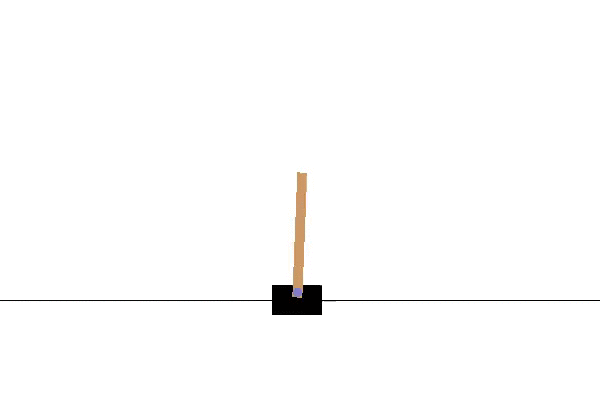
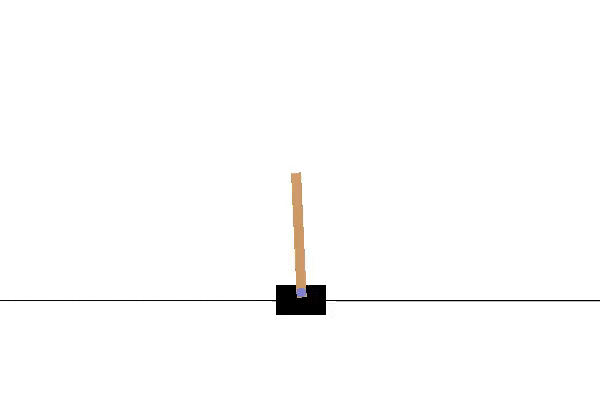
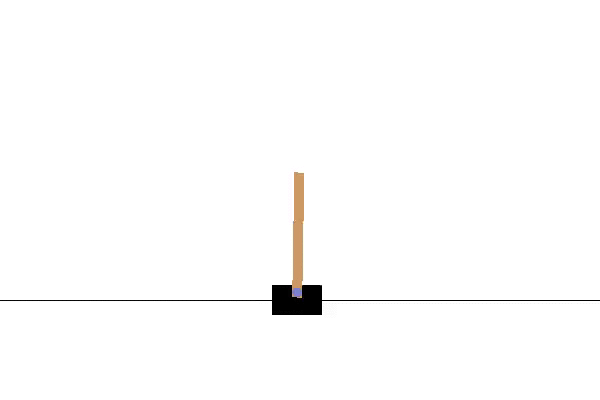

In [39]:
best_agent.demo()

In [40]:
dueling_dqn_max_t, dueling_dqn_max_r, dueling_dqn_max_s, \
dueling_dqn_max_sec, dueling_dqn_max_rt = np.max(dueling_dqn_results, axis=0).T
dueling_dqn_min_t, dueling_dqn_min_r, dueling_dqn_min_s, \
dueling_dqn_min_sec, dueling_dqn_min_rt = np.min(dueling_dqn_results, axis=0).T
dueling_dqn_mean_t, dueling_dqn_mean_r, dueling_dqn_mean_s, \
dueling_dqn_mean_sec, dueling_dqn_mean_rt = np.mean(dueling_dqn_results, axis=0).T
dueling_dqn_x = np.arange(np.max(
    (len(dueling_dqn_mean_s), len(ddqn_mean_s), len(dqn_mean_s), len(nfq_mean_s))))

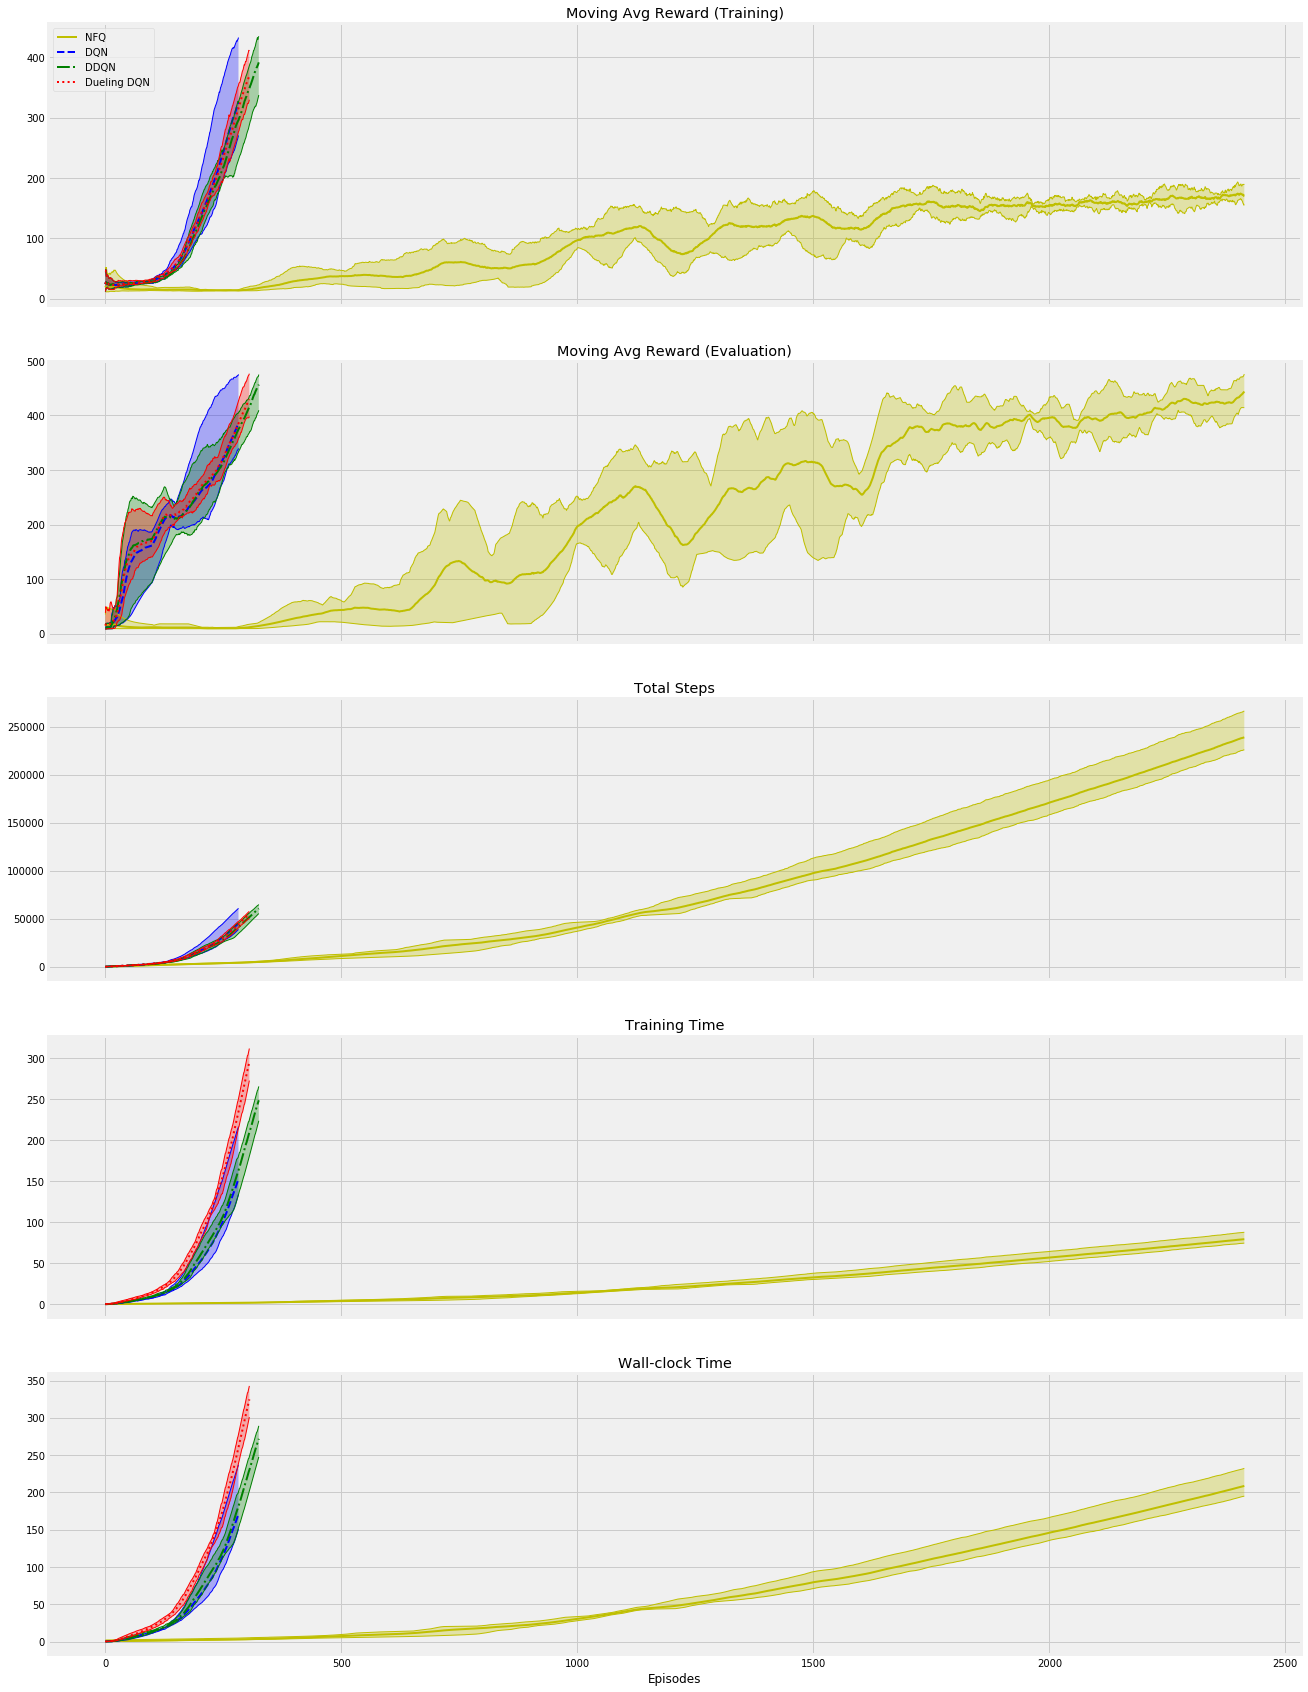

In [41]:
fig, axs = plt.subplots(5, 1, figsize=(20,30), sharey=False, sharex=True)

# NFQ
axs[0].plot(nfq_max_r, 'y', linewidth=1)
axs[0].plot(nfq_min_r, 'y', linewidth=1)
axs[0].plot(nfq_mean_r, 'y', label='NFQ', linewidth=2)
axs[0].fill_between(nfq_x, nfq_min_r, nfq_max_r, facecolor='y', alpha=0.3)

axs[1].plot(nfq_max_s, 'y', linewidth=1)
axs[1].plot(nfq_min_s, 'y', linewidth=1)
axs[1].plot(nfq_mean_s, 'y', label='NFQ', linewidth=2)
axs[1].fill_between(nfq_x, nfq_min_s, nfq_max_s, facecolor='y', alpha=0.3)

axs[2].plot(nfq_max_t, 'y', linewidth=1)
axs[2].plot(nfq_min_t, 'y', linewidth=1)
axs[2].plot(nfq_mean_t, 'y', label='NFQ', linewidth=2)
axs[2].fill_between(nfq_x, nfq_min_t, nfq_max_t, facecolor='y', alpha=0.3)

axs[3].plot(nfq_max_sec, 'y', linewidth=1)
axs[3].plot(nfq_min_sec, 'y', linewidth=1)
axs[3].plot(nfq_mean_sec, 'y', label='NFQ', linewidth=2)
axs[3].fill_between(nfq_x, nfq_min_sec, nfq_max_sec, facecolor='y', alpha=0.3)

axs[4].plot(nfq_max_rt, 'y', linewidth=1)
axs[4].plot(nfq_min_rt, 'y', linewidth=1)
axs[4].plot(nfq_mean_rt, 'y', label='NFQ', linewidth=2)
axs[4].fill_between(nfq_x, nfq_min_rt, nfq_max_rt, facecolor='y', alpha=0.3)

# DQN
axs[0].plot(dqn_max_r, 'b', linewidth=1)
axs[0].plot(dqn_min_r, 'b', linewidth=1)
axs[0].plot(dqn_mean_r, 'b--', label='DQN', linewidth=2)
axs[0].fill_between(dqn_x, dqn_min_r, dqn_max_r, facecolor='b', alpha=0.3)

axs[1].plot(dqn_max_s, 'b', linewidth=1)
axs[1].plot(dqn_min_s, 'b', linewidth=1)
axs[1].plot(dqn_mean_s, 'b--', label='DQN', linewidth=2)
axs[1].fill_between(dqn_x, dqn_min_s, dqn_max_s, facecolor='b', alpha=0.3)

axs[2].plot(dqn_max_t, 'b', linewidth=1)
axs[2].plot(dqn_min_t, 'b', linewidth=1)
axs[2].plot(dqn_mean_t, 'b--', label='DQN', linewidth=2)
axs[2].fill_between(dqn_x, dqn_min_t, dqn_max_t, facecolor='b', alpha=0.3)

axs[3].plot(dqn_max_sec, 'b', linewidth=1)
axs[3].plot(dqn_min_sec, 'b', linewidth=1)
axs[3].plot(dqn_mean_sec, 'b--', label='DQN', linewidth=2)
axs[3].fill_between(dqn_x, dqn_min_sec, dqn_max_sec, facecolor='b', alpha=0.3)

axs[4].plot(dqn_max_rt, 'b', linewidth=1)
axs[4].plot(dqn_min_rt, 'b', linewidth=1)
axs[4].plot(dqn_mean_rt, 'b--', label='DQN', linewidth=2)
axs[4].fill_between(dqn_x, dqn_min_rt, dqn_max_rt, facecolor='b', alpha=0.3)

# DDQN
axs[0].plot(ddqn_max_r, 'g', linewidth=1)
axs[0].plot(ddqn_min_r, 'g', linewidth=1)
axs[0].plot(ddqn_mean_r, 'g-.', label='DDQN', linewidth=2)
axs[0].fill_between(ddqn_x, ddqn_min_r, ddqn_max_r, facecolor='g', alpha=0.3)

axs[1].plot(ddqn_max_s, 'g', linewidth=1)
axs[1].plot(ddqn_min_s, 'g', linewidth=1)
axs[1].plot(ddqn_mean_s, 'g-.', label='DDQN', linewidth=2)
axs[1].fill_between(ddqn_x, ddqn_min_s, ddqn_max_s, facecolor='g', alpha=0.3)

axs[2].plot(ddqn_max_t, 'g', linewidth=1)
axs[2].plot(ddqn_min_t, 'g', linewidth=1)
axs[2].plot(ddqn_mean_t, 'g-.', label='DDQN', linewidth=2)
axs[2].fill_between(ddqn_x, ddqn_min_t, ddqn_max_t, facecolor='g', alpha=0.3)

axs[3].plot(ddqn_max_sec, 'g', linewidth=1)
axs[3].plot(ddqn_min_sec, 'g', linewidth=1)
axs[3].plot(ddqn_mean_sec, 'g-.', label='DDQN', linewidth=2)
axs[3].fill_between(ddqn_x, ddqn_min_sec, ddqn_max_sec, facecolor='g', alpha=0.3)

axs[4].plot(ddqn_max_rt, 'g', linewidth=1)
axs[4].plot(ddqn_min_rt, 'g', linewidth=1)
axs[4].plot(ddqn_mean_rt, 'g-.', label='DDQN', linewidth=2)
axs[4].fill_between(ddqn_x, ddqn_min_rt, ddqn_max_rt, facecolor='g', alpha=0.3)

# Dueling DQN
axs[0].plot(dueling_dqn_max_r, 'r', linewidth=1)
axs[0].plot(dueling_dqn_min_r, 'r', linewidth=1)
axs[0].plot(dueling_dqn_mean_r, 'r:', label='Dueling DQN', linewidth=2)
axs[0].fill_between(
    dueling_dqn_x, dueling_dqn_min_r, dueling_dqn_max_r, facecolor='r', alpha=0.3)

axs[1].plot(dueling_dqn_max_s, 'r', linewidth=1)
axs[1].plot(dueling_dqn_min_s, 'r', linewidth=1)
axs[1].plot(dueling_dqn_mean_s, 'r:', label='Dueling DQN', linewidth=2)
axs[1].fill_between(
    dueling_dqn_x, dueling_dqn_min_s, dueling_dqn_max_s, facecolor='r', alpha=0.3)

axs[2].plot(dueling_dqn_max_t, 'r', linewidth=1)
axs[2].plot(dueling_dqn_min_t, 'r', linewidth=1)
axs[2].plot(dueling_dqn_mean_t, 'r:', label='Dueling DQN', linewidth=2)
axs[2].fill_between(
    dueling_dqn_x, dueling_dqn_min_t, dueling_dqn_max_t, facecolor='r', alpha=0.3)

axs[3].plot(dueling_dqn_max_sec, 'r', linewidth=1)
axs[3].plot(dueling_dqn_min_sec, 'r', linewidth=1)
axs[3].plot(dueling_dqn_mean_sec, 'r:', label='Dueling DQN', linewidth=2)
axs[3].fill_between(
    dueling_dqn_x, dueling_dqn_min_sec, dueling_dqn_max_sec, facecolor='r', alpha=0.3)

axs[4].plot(dueling_dqn_max_rt, 'r', linewidth=1)
axs[4].plot(dueling_dqn_min_rt, 'r', linewidth=1)
axs[4].plot(dueling_dqn_mean_rt, 'r:', label='Dueling DQN', linewidth=2)
axs[4].fill_between(
    dueling_dqn_x, dueling_dqn_min_rt, dueling_dqn_max_rt, facecolor='r', alpha=0.3)

# ALL
axs[0].set_title('Moving Avg Reward (Training)')
axs[1].set_title('Moving Avg Reward (Evaluation)')
axs[2].set_title('Total Steps')
axs[3].set_title('Training Time')
axs[4].set_title('Wall-clock Time')
plt.xlabel('Episodes')
axs[0].legend(loc='upper left')
plt.show()

# PER

In [42]:
class PrioritizedReplayBuffer():
    def __init__(self, 
                 max_samples=10000, 
                 batch_size=64, 
                 rank_based=False,
                 alpha=0.6, 
                 beta0=0.1, 
                 beta_rate=0.99992):
        self.max_samples = max_samples
        self.memory = np.empty(shape=(self.max_samples, 2), dtype=np.ndarray)
        self.batch_size = batch_size
        self.n_entries = 0
        self.next_index = 0
        self.td_error_index = 0
        self.sample_index = 1
        self.rank_based = rank_based # if not rank_based, then proportional
        self.alpha = alpha # how much prioritization to use 0 is uniform (no priority), 1 is full priority
        self.beta = beta0 # bias correction 0 is no correction 1 is full correction
        self.beta0 = beta0 # beta0 is just beta's initial value
        self.beta_rate = beta_rate

    def update(self, idxs, td_errors):
        self.memory[idxs, self.td_error_index] = np.abs(td_errors)
        if self.rank_based:
            sorted_arg = self.memory[:self.n_entries, self.td_error_index].argsort()[::-1]
            self.memory[:self.n_entries] = self.memory[sorted_arg]

    def store(self, sample):
        priority = 1.0
        if self.n_entries > 0:
            priority = self.memory[
                :self.n_entries, 
                self.td_error_index].max()
        self.memory[self.next_index, 
                    self.td_error_index] = priority
        self.memory[self.next_index, 
                    self.sample_index] = np.array(sample)
        self.n_entries = min(self.n_entries + 1, self.max_samples)
        self.next_index += 1
        self.next_index = self.next_index % self.max_samples

    def _update_beta(self):
        self.beta = min(1.0, self.beta * self.beta_rate**-1)
        return self.beta

    def sample(self, batch_size=None):
        batch_size = self.batch_size if batch_size == None else batch_size
        self._update_beta()
        entries = self.memory[:self.n_entries]

        if self.rank_based:
            priorities = 1/(np.arange(self.n_entries) + 1)
        else: # proportional
            priorities = entries[:, self.td_error_index] + EPS
        scaled_priorities = priorities**self.alpha        
        probs = np.array(scaled_priorities/np.sum(scaled_priorities), dtype=np.float64)

        weights = (self.n_entries * probs)**-self.beta
        normalized_weights = weights/weights.max()
        idxs = np.random.choice(self.n_entries, batch_size, replace=False, p=probs)
        samples = np.array([entries[idx] for idx in idxs])
        
        samples_stacks = [np.vstack(batch_type) for batch_type in np.vstack(samples[:, self.sample_index]).T]
        idxs_stack = np.vstack(idxs)
        weights_stack = np.vstack(normalized_weights[idxs])
        return idxs_stack, weights_stack, samples_stacks

    def __len__(self):
        return self.n_entries
    
    def __repr__(self):
        return str(self.memory[:self.n_entries])
    
    def __str__(self):
        return str(self.memory[:self.n_entries])

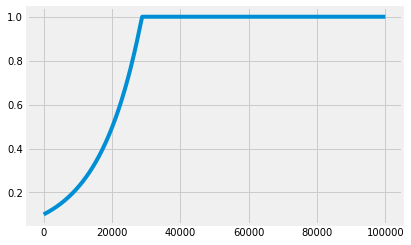

In [43]:
b = PrioritizedReplayBuffer()
plt.plot([b._update_beta() for _ in range(100000)])
plt.show()

In [44]:
class PER():
    def __init__(self, 
                 reply_buffer_fn, 
                 value_model_fn, 
                 value_optimizer_fn, 
                 value_optimizer_lr,
                 max_gradient_norm,
                 training_strategy_fn,
                 evaluation_strategy_fn,
                 n_warmup_batches,
                 update_target_every_steps,
                 tau):
        self.replay_buffer_fn = replay_buffer_fn
        self.value_model_fn = value_model_fn
        self.value_optimizer_fn = value_optimizer_fn
        self.value_optimizer_lr = value_optimizer_lr
        self.max_gradient_norm = max_gradient_norm
        self.training_strategy_fn = training_strategy_fn
        self.evaluation_strategy_fn = evaluation_strategy_fn
        self.n_warmup_batches = n_warmup_batches
        self.update_target_every_steps = update_target_every_steps
        self.tau = tau

    def optimize_model(self, experiences):
        idxs, weights, \
        (states, actions, rewards, next_states, is_terminals) = experiences
        weights = self.online_model.numpy_float_to_device(weights)
        batch_size = len(is_terminals)
        
        argmax_a_q_sp = self.online_model(next_states).max(1)[1]
        q_sp = self.target_model(next_states).detach()
        max_a_q_sp = q_sp[
            np.arange(batch_size), argmax_a_q_sp].unsqueeze(1)
        target_q_sa = rewards + (self.gamma * max_a_q_sp * (1 - is_terminals))
        q_sa = self.online_model(states).gather(1, actions)

        td_error = q_sa - target_q_sa
        value_loss = (weights * td_error).pow(2).mul(0.5).mean()
        self.value_optimizer.zero_grad()
        value_loss.backward()        
        torch.nn.utils.clip_grad_norm_(self.online_model.parameters(), 
                                       self.max_gradient_norm)
        self.value_optimizer.step()

        priorities = np.abs(td_error.detach().cpu().numpy())
        self.replay_buffer.update(idxs, priorities)

    def interaction_step(self, state, env):
        action = self.training_strategy.select_action(self.online_model, state)
        new_state, reward, is_terminal, _ = env.step(action)
        past_limit_enforced = hasattr(env, '_past_limit') and env._past_limit()
        is_failure = is_terminal and not past_limit_enforced

        experience = (state, action, reward, new_state, float(is_failure))
        self.replay_buffer.store(experience)
        self.episode_reward[-1] += reward
        self.episode_timestep[-1] += 1
        self.episode_exploration[-1] += int(self.training_strategy.exploratory_action_taken)
        return new_state, is_terminal
    
    def update_network(self, tau=None):
        tau = self.tau if tau is None else tau
        for target, online in zip(self.target_model.parameters(), 
                                  self.online_model.parameters()):
            target_ratio = (1.0 - self.tau) * target.data
            online_ratio = self.tau * online.data
            mixed_weights = target_ratio + online_ratio
            target.data.copy_(mixed_weights)

    def train(self, make_env_fn, make_env_kargs, seed, gamma, 
              max_minutes, max_episodes, goal_mean_100_reward):
        training_start, last_debug_time = time.time(), float('-inf')

        self.make_env_fn = make_env_fn
        self.make_env_kargs = make_env_kargs
        self.seed = seed
        self.gamma = gamma
        
        env = self.make_env_fn(**self.make_env_kargs, seed=self.seed)
        torch.manual_seed(self.seed) ; np.random.seed(self.seed) ; random.seed(self.seed)
    
        nS, nA = env.observation_space.shape[0], env.action_space.n
        self.episode_timestep = []
        self.episode_reward = []
        self.episode_seconds = []
        self.evaluation_scores = []        
        self.episode_exploration = []
        
        self.target_model = self.value_model_fn(nS, nA)
        self.online_model = self.value_model_fn(nS, nA)
        self.update_network(tau=1.0)

        self.value_optimizer = self.value_optimizer_fn(self.online_model, 
                                                       self.value_optimizer_lr)

        self.replay_buffer = self.replay_buffer_fn()
        self.training_strategy = training_strategy_fn()
        self.evaluation_strategy = evaluation_strategy_fn() 
                    
        result = np.empty((max_episodes, 5))
        result[:] = np.nan
        training_time = 0
        for episode in range(1, max_episodes + 1):
            episode_start = time.time()
            
            state, is_terminal = env.reset(), False
            self.episode_reward.append(0.0)
            self.episode_timestep.append(0.0)
            self.episode_exploration.append(0.0)

            for step in count():
                state, is_terminal = self.interaction_step(state, env)
                
                min_samples = self.replay_buffer.batch_size * self.n_warmup_batches
                if len(self.replay_buffer) > min_samples:
                    experiences = self.replay_buffer.sample()
                    idxs, weights, samples = experiences
                    experiences = self.online_model.load(samples)
                    experiences = (idxs, weights) + (experiences,)
                    self.optimize_model(experiences)
                
                if np.sum(self.episode_timestep) % self.update_target_every_steps == 0:
                    self.update_network()

                if is_terminal:
                    break
            
            # stats
            episode_elapsed = time.time() - episode_start
            self.episode_seconds.append(episode_elapsed)
            training_time += episode_elapsed
            evaluation_score, _ = self.evaluate(self.online_model, env)
            total_step = int(np.sum(self.episode_timestep))
            self.evaluation_scores.append(evaluation_score)
            
            mean_10_reward = np.mean(self.episode_reward[-10:])
            std_10_reward = np.std(self.episode_reward[-10:])
            mean_100_reward = np.mean(self.episode_reward[-100:])
            std_100_reward = np.std(self.episode_reward[-100:])
            mean_100_eval_score = np.mean(self.evaluation_scores[-100:])
            std_100_eval_score = np.std(self.evaluation_scores[-100:])
            lst_100_exp_rat = np.array(
                self.episode_exploration[-100:])/np.array(self.episode_timestep[-100:])
            mean_100_exp_rat = np.mean(lst_100_exp_rat)
            std_100_exp_rat = np.std(lst_100_exp_rat)
            
            wallclock_elapsed = time.time() - training_start
            result[episode-1] = total_step, mean_100_reward, \
                mean_100_eval_score, training_time, wallclock_elapsed
            
            reached_debug_time = time.time() - last_debug_time >= LEAVE_PRINT_EVERY_N_SECS
            reached_max_minutes = wallclock_elapsed >= max_minutes * 60
            reached_max_episodes = episode >= max_episodes
            reached_goal_mean_reward = mean_100_eval_score >= goal_mean_100_reward
            training_is_over = reached_max_minutes or \
                               reached_max_episodes or \
                               reached_goal_mean_reward
            elapsed_str = time.strftime("%M:%S", time.gmtime(time.time() - training_start))
            debug_message = 'elp {}, ep {:04}, stps {:06}, '
            debug_message += 'avr 10 {:05.1f}\u00B1{:05.1f}, '
            debug_message += '100 {:05.1f}\u00B1{:05.1f}, '
            debug_message += 'ex 100 {:02.1f}\u00B1{:02.1f}, '
            debug_message += 'eval {:05.1f}\u00B1{:05.1f}'
            debug_message = debug_message.format(
                elapsed_str, episode-1, total_step, mean_10_reward, std_10_reward, 
                mean_100_reward, std_100_reward, mean_100_exp_rat, std_100_exp_rat,
                mean_100_eval_score, std_100_eval_score)
            print(debug_message, end='\r', flush=True)
            if reached_debug_time or training_is_over:
                print(ERASE_LINE + debug_message, flush=True)
                last_debug_time = time.time()
            if training_is_over:
                if reached_max_minutes: print(u'--> reached_max_minutes \u2715')
                if reached_max_episodes: print(u'--> reached_max_episodes \u2715')
                if reached_goal_mean_reward: print(u'--> reached_goal_mean_reward \u2713')
                break
                
        final_eval_score, score_std = self.evaluate(self.online_model, env, n_episodes=100)
        wallclock_time = time.time() - training_start
        print('Training complete.')
        print('Final evaluation score {:.2f}\u00B1{:.2f} in {:.2f}s training time,'
              ' {:.2f}s wall-clock time.\n'.format(
                  final_eval_score, score_std, training_time, wallclock_time))
        env.close() ; del env
        return result, final_eval_score, training_time, wallclock_time
    
    def evaluate(self, eval_policy_model, eval_env, n_episodes=1):
        rs = []
        for _ in range(n_episodes):
            s, d = eval_env.reset(), False
            rs.append(0)
            for _ in count():
                a = self.evaluation_strategy.select_action(self.online_model, s)
                s, r, d, _ = eval_env.step(a)
                rs[-1] += r
                if d: break
        return np.mean(rs), np.std(rs)
    
    def demo(self, title='Trained {} Agent', n_episodes=10, max_n_videos=3):          
        env = self.make_env_fn(**self.make_env_kargs, monitor_mode='evaluation')
        self.evaluate(self.online_model, env, n_episodes=n_episodes)
        env.close()
        data = get_gif_html(env_videos=env.videos, 
                            title=title.format(self.__class__.__name__),
                            max_n_videos=max_n_videos)
        del env
        return HTML(data=data)

In [45]:
per_results = []
best_agent, best_eval_score = None, float('-inf')
for seed in [12, 34, 56, 78, 90]:
    environment_settings = {
        'env_name': 'CartPole-v1',
        'gamma': 1.00,
        'max_minutes': 20,
        'max_episodes': 10000,
        'goal_mean_100_reward': 475
    }
    
    value_model_fn = lambda nS, nA: FCDuelingQ(nS, nA, hidden_dims=(512,128))
    value_optimizer_fn = lambda net, lr: optim.RMSprop(net.parameters(), lr=lr)
    value_optimizer_lr = 0.0007
    max_gradient_norm = float('inf')

    training_strategy_fn = lambda: EGreedyLinearStrategy(init_epsilon=1.0, 
                                                         decay_rate=0.9999, 
                                                         min_epsilon=0.3)
    evaluation_strategy_fn = lambda: GreedyStrategy()

    # replay_buffer_fn =  lambda: ReplayBuffer(max_size=10000, batch_size=64)
    # replay_buffer_fn =  lambda: PrioritizedReplayBuffer(
    #     max_samples=10000, batch_size=64, rank_based=True, 
    #     alpha=0.6, beta0=0.1, beta_rate=0.99992)
    replay_buffer_fn =  lambda: PrioritizedReplayBuffer(
        max_samples=10000, batch_size=64, rank_based=False,
        alpha=0.6, beta0=0.1, beta_rate=0.99992)
    n_warmup_batches = 5
    update_target_every_steps = 1
    tau = 0.1

    env_name, gamma, max_minutes, \
    max_episodes, goal_mean_100_reward = environment_settings.values()
    agent = PER(replay_buffer_fn, 
                value_model_fn, 
                value_optimizer_fn, 
                value_optimizer_lr,
                max_gradient_norm,
                training_strategy_fn,
                evaluation_strategy_fn,
                n_warmup_batches,
                update_target_every_steps,
                tau)

    make_env_fn, make_env_kargs = get_make_env_fn(env_name=env_name)
    result, final_eval_score, training_time, wallclock_time = agent.train(
        make_env_fn, make_env_kargs, seed, gamma, max_minutes, max_episodes, goal_mean_100_reward)
    per_results.append(result)
    if final_eval_score > best_eval_score:
        best_eval_score = final_eval_score
        best_agent = agent
per_results = np.array(per_results)
_ = BEEP()

elp 00:00, ep 0000, stps 000016, avr 10 016.0±000.0, 100 016.0±000.0, ex 100 0.3±0.0, eval 009.0±000.0
elp 00:20, ep 0097, stps 002671, avr 10 035.2±020.1, 100 027.3±015.1, ex 100 0.5±0.1, eval 171.7±121.8
elp 00:41, ep 0141, stps 005280, avr 10 065.4±044.4, 100 043.2±029.7, ex 100 0.4±0.1, eval 206.6±071.2
elp 01:02, ep 0161, stps 007950, avr 10 171.6±032.2, 100 064.1±054.0, ex 100 0.4±0.1, eval 224.3±076.1
elp 01:23, ep 0171, stps 010537, avr 10 258.7±077.8, 100 087.9±080.9, ex 100 0.3±0.1, eval 237.1±077.4
elp 01:45, ep 0184, stps 013135, avr 10 188.0±027.0, 100 109.3±087.3, ex 100 0.3±0.1, eval 250.2±081.0
elp 02:07, ep 0198, stps 015709, avr 10 182.8±067.2, 100 129.7±087.9, ex 100 0.3±0.1, eval 259.7±083.6
elp 02:30, ep 0206, stps 018336, avr 10 311.5±080.5, 100 152.3±101.3, ex 100 0.3±0.1, eval 272.9±090.2
elp 02:52, ep 0217, stps 020907, avr 10 244.1±071.7, 100 172.5±099.8, ex 100 0.2±0.1, eval 284.7±090.6
elp 03:13, ep 0226, stps 023477, avr 10 283.6±101.7, 100 192.3±103.1, ex 

elp 02:26, ep 0197, stps 017116, avr 10 267.7±106.3, 100 144.0±117.7, ex 100 0.3±0.1, eval 313.8±111.2
elp 02:46, ep 0205, stps 019336, avr 10 292.8±107.1, 100 163.7±120.9, ex 100 0.3±0.1, eval 325.3±108.5
elp 03:06, ep 0213, stps 021479, avr 10 289.4±126.9, 100 182.6±121.8, ex 100 0.2±0.1, eval 338.1±110.7
elp 03:29, ep 0220, stps 023861, avr 10 340.1±145.5, 100 203.4±127.5, ex 100 0.2±0.1, eval 355.0±111.6
elp 03:49, ep 0227, stps 026078, avr 10 313.5±159.4, 100 222.4±130.2, ex 100 0.2±0.1, eval 373.7±111.3
elp 04:11, ep 0233, stps 028437, avr 10 330.7±172.0, 100 241.0±136.1, ex 100 0.2±0.1, eval 389.0±108.6
elp 04:34, ep 0239, stps 030936, avr 10 385.8±158.6, 100 260.7±140.5, ex 100 0.2±0.1, eval 402.1±105.7
elp 04:54, ep 0244, stps 033353, avr 10 441.6±121.9, 100 280.2±142.6, ex 100 0.2±0.1, eval 410.9±103.2
elp 05:17, ep 0250, stps 035945, avr 10 459.2±122.4, 100 299.9±143.8, ex 100 0.2±0.1, eval 420.5±100.7
elp 05:38, ep 0256, stps 038347, avr 10 399.4±138.8, 100 314.3±142.1, ex 


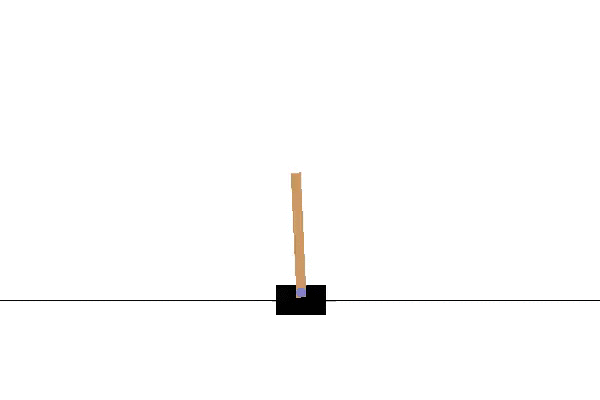
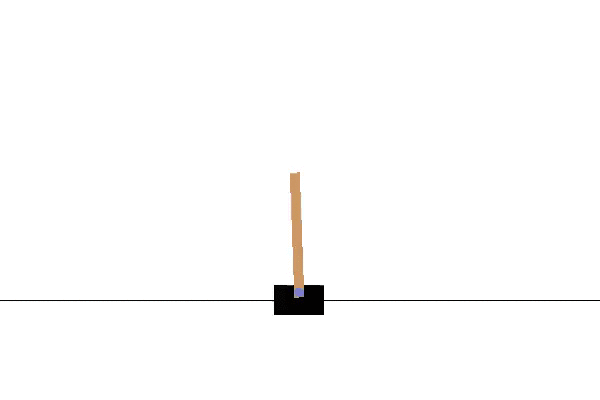
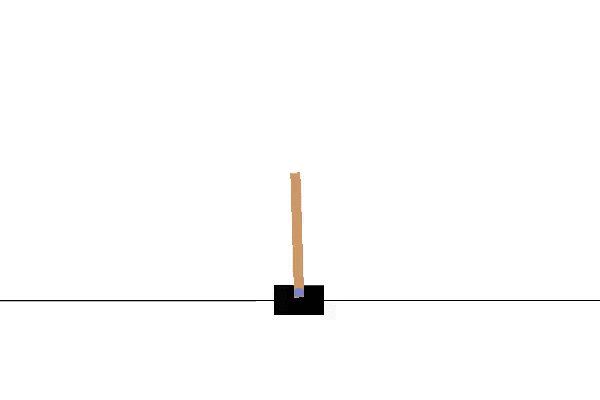

In [46]:
best_agent.demo()

In [47]:
per_max_t, per_max_r, per_max_s, per_max_sec, per_max_rt = np.max(per_results, axis=0).T
per_min_t, per_min_r, per_min_s, per_min_sec, per_min_rt = np.min(per_results, axis=0).T
per_mean_t, per_mean_r, per_mean_s, per_mean_sec, per_mean_rt = np.mean(per_results, axis=0).T
per_x = np.arange(np.max(
    (len(per_mean_s), len(dueling_dqn_mean_s), len(ddqn_mean_s), len(dqn_mean_s))))

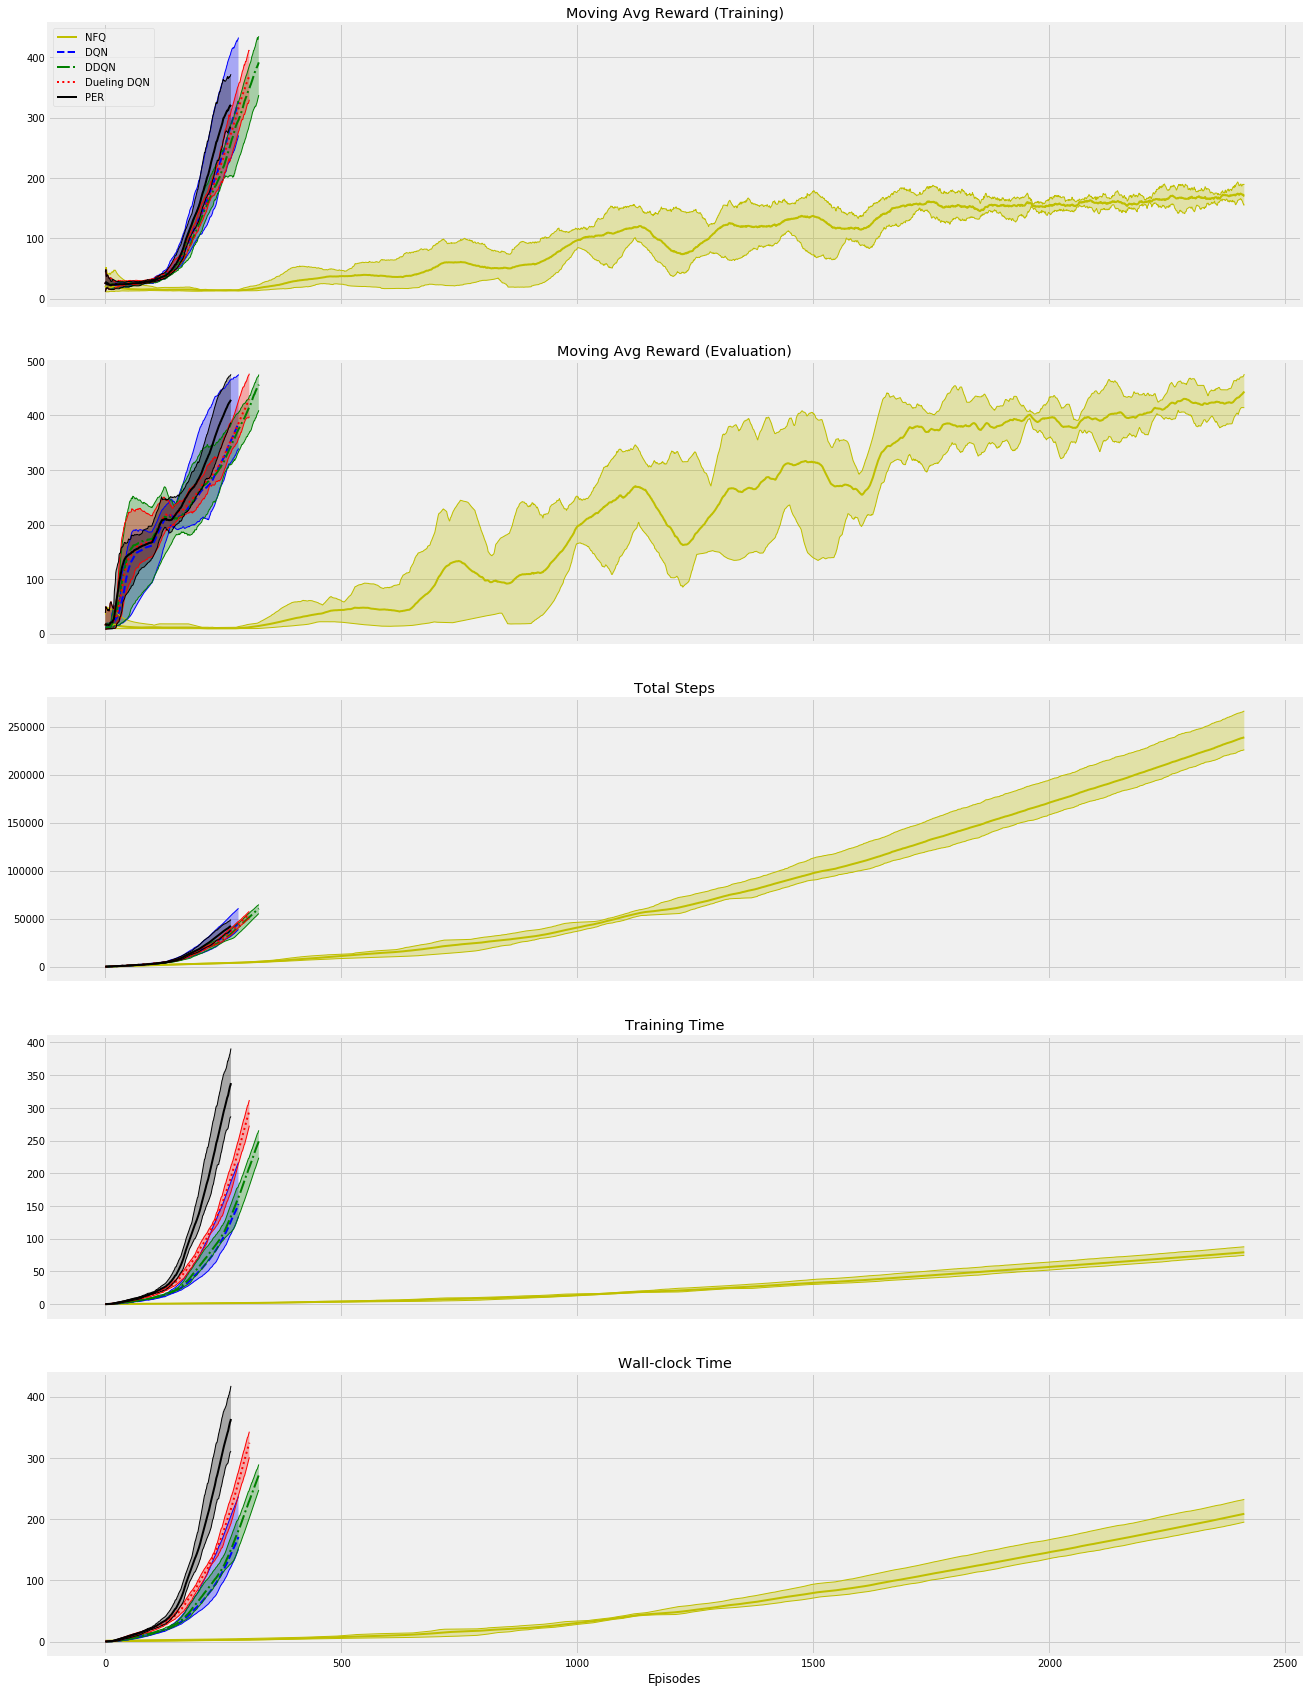

In [48]:
fig, axs = plt.subplots(5, 1, figsize=(20,30), sharey=False, sharex=True)

# NFQ
axs[0].plot(nfq_max_r, 'y', linewidth=1)
axs[0].plot(nfq_min_r, 'y', linewidth=1)
axs[0].plot(nfq_mean_r, 'y', label='NFQ', linewidth=2)
axs[0].fill_between(nfq_x, nfq_min_r, nfq_max_r, facecolor='y', alpha=0.3)

axs[1].plot(nfq_max_s, 'y', linewidth=1)
axs[1].plot(nfq_min_s, 'y', linewidth=1)
axs[1].plot(nfq_mean_s, 'y', label='NFQ', linewidth=2)
axs[1].fill_between(nfq_x, nfq_min_s, nfq_max_s, facecolor='y', alpha=0.3)

axs[2].plot(nfq_max_t, 'y', linewidth=1)
axs[2].plot(nfq_min_t, 'y', linewidth=1)
axs[2].plot(nfq_mean_t, 'y', label='NFQ', linewidth=2)
axs[2].fill_between(nfq_x, nfq_min_t, nfq_max_t, facecolor='y', alpha=0.3)

axs[3].plot(nfq_max_sec, 'y', linewidth=1)
axs[3].plot(nfq_min_sec, 'y', linewidth=1)
axs[3].plot(nfq_mean_sec, 'y', label='NFQ', linewidth=2)
axs[3].fill_between(nfq_x, nfq_min_sec, nfq_max_sec, facecolor='y', alpha=0.3)

axs[4].plot(nfq_max_rt, 'y', linewidth=1)
axs[4].plot(nfq_min_rt, 'y', linewidth=1)
axs[4].plot(nfq_mean_rt, 'y', label='NFQ', linewidth=2)
axs[4].fill_between(nfq_x, nfq_min_rt, nfq_max_rt, facecolor='y', alpha=0.3)

# DQN
axs[0].plot(dqn_max_r, 'b', linewidth=1)
axs[0].plot(dqn_min_r, 'b', linewidth=1)
axs[0].plot(dqn_mean_r, 'b--', label='DQN', linewidth=2)
axs[0].fill_between(dqn_x, dqn_min_r, dqn_max_r, facecolor='b', alpha=0.3)

axs[1].plot(dqn_max_s, 'b', linewidth=1)
axs[1].plot(dqn_min_s, 'b', linewidth=1)
axs[1].plot(dqn_mean_s, 'b--', label='DQN', linewidth=2)
axs[1].fill_between(dqn_x, dqn_min_s, dqn_max_s, facecolor='b', alpha=0.3)

axs[2].plot(dqn_max_t, 'b', linewidth=1)
axs[2].plot(dqn_min_t, 'b', linewidth=1)
axs[2].plot(dqn_mean_t, 'b--', label='DQN', linewidth=2)
axs[2].fill_between(dqn_x, dqn_min_t, dqn_max_t, facecolor='b', alpha=0.3)

axs[3].plot(dqn_max_sec, 'b', linewidth=1)
axs[3].plot(dqn_min_sec, 'b', linewidth=1)
axs[3].plot(dqn_mean_sec, 'b--', label='DQN', linewidth=2)
axs[3].fill_between(dqn_x, dqn_min_sec, dqn_max_sec, facecolor='b', alpha=0.3)

axs[4].plot(dqn_max_rt, 'b', linewidth=1)
axs[4].plot(dqn_min_rt, 'b', linewidth=1)
axs[4].plot(dqn_mean_rt, 'b--', label='DQN', linewidth=2)
axs[4].fill_between(dqn_x, dqn_min_rt, dqn_max_rt, facecolor='b', alpha=0.3)

# DDQN
axs[0].plot(ddqn_max_r, 'g', linewidth=1)
axs[0].plot(ddqn_min_r, 'g', linewidth=1)
axs[0].plot(ddqn_mean_r, 'g-.', label='DDQN', linewidth=2)
axs[0].fill_between(ddqn_x, ddqn_min_r, ddqn_max_r, facecolor='g', alpha=0.3)

axs[1].plot(ddqn_max_s, 'g', linewidth=1)
axs[1].plot(ddqn_min_s, 'g', linewidth=1)
axs[1].plot(ddqn_mean_s, 'g-.', label='DDQN', linewidth=2)
axs[1].fill_between(ddqn_x, ddqn_min_s, ddqn_max_s, facecolor='g', alpha=0.3)

axs[2].plot(ddqn_max_t, 'g', linewidth=1)
axs[2].plot(ddqn_min_t, 'g', linewidth=1)
axs[2].plot(ddqn_mean_t, 'g-.', label='DDQN', linewidth=2)
axs[2].fill_between(ddqn_x, ddqn_min_t, ddqn_max_t, facecolor='g', alpha=0.3)

axs[3].plot(ddqn_max_sec, 'g', linewidth=1)
axs[3].plot(ddqn_min_sec, 'g', linewidth=1)
axs[3].plot(ddqn_mean_sec, 'g-.', label='DDQN', linewidth=2)
axs[3].fill_between(ddqn_x, ddqn_min_sec, ddqn_max_sec, facecolor='g', alpha=0.3)

axs[4].plot(ddqn_max_rt, 'g', linewidth=1)
axs[4].plot(ddqn_min_rt, 'g', linewidth=1)
axs[4].plot(ddqn_mean_rt, 'g-.', label='DDQN', linewidth=2)
axs[4].fill_between(ddqn_x, ddqn_min_rt, ddqn_max_rt, facecolor='g', alpha=0.3)

# Dueling DQN
axs[0].plot(dueling_dqn_max_r, 'r', linewidth=1)
axs[0].plot(dueling_dqn_min_r, 'r', linewidth=1)
axs[0].plot(dueling_dqn_mean_r, 'r:', label='Dueling DQN', linewidth=2)
axs[0].fill_between(
    dueling_dqn_x, dueling_dqn_min_r, dueling_dqn_max_r, facecolor='r', alpha=0.3)

axs[1].plot(dueling_dqn_max_s, 'r', linewidth=1)
axs[1].plot(dueling_dqn_min_s, 'r', linewidth=1)
axs[1].plot(dueling_dqn_mean_s, 'r:', label='Dueling DQN', linewidth=2)
axs[1].fill_between(
    dueling_dqn_x, dueling_dqn_min_s, dueling_dqn_max_s, facecolor='r', alpha=0.3)

axs[2].plot(dueling_dqn_max_t, 'r', linewidth=1)
axs[2].plot(dueling_dqn_min_t, 'r', linewidth=1)
axs[2].plot(dueling_dqn_mean_t, 'r:', label='Dueling DQN', linewidth=2)
axs[2].fill_between(
    dueling_dqn_x, dueling_dqn_min_t, dueling_dqn_max_t, facecolor='r', alpha=0.3)

axs[3].plot(dueling_dqn_max_sec, 'r', linewidth=1)
axs[3].plot(dueling_dqn_min_sec, 'r', linewidth=1)
axs[3].plot(dueling_dqn_mean_sec, 'r:', label='Dueling DQN', linewidth=2)
axs[3].fill_between(
    dueling_dqn_x, dueling_dqn_min_sec, dueling_dqn_max_sec, facecolor='r', alpha=0.3)

axs[4].plot(dueling_dqn_max_rt, 'r', linewidth=1)
axs[4].plot(dueling_dqn_min_rt, 'r', linewidth=1)
axs[4].plot(dueling_dqn_mean_rt, 'r:', label='Dueling DQN', linewidth=2)
axs[4].fill_between(
    dueling_dqn_x, dueling_dqn_min_rt, dueling_dqn_max_rt, facecolor='r', alpha=0.3)

# PER
axs[0].plot(per_max_r, 'k', linewidth=1)
axs[0].plot(per_min_r, 'k', linewidth=1)
axs[0].plot(per_mean_r, 'k', label='PER', linewidth=2)
axs[0].fill_between(per_x, per_min_r, per_max_r, facecolor='k', alpha=0.3)

axs[1].plot(per_max_s, 'k', linewidth=1)
axs[1].plot(per_min_s, 'k', linewidth=1)
axs[1].plot(per_mean_s, 'k', label='PER', linewidth=2)
axs[1].fill_between(per_x, per_min_s, per_max_s, facecolor='k', alpha=0.3)

axs[2].plot(per_max_t, 'k', linewidth=1)
axs[2].plot(per_min_t, 'k', linewidth=1)
axs[2].plot(per_mean_t, 'k', label='PER', linewidth=2)
axs[2].fill_between(per_x, per_min_t, per_max_t, facecolor='k', alpha=0.3)

axs[3].plot(per_max_sec, 'k', linewidth=1)
axs[3].plot(per_min_sec, 'k', linewidth=1)
axs[3].plot(per_mean_sec, 'k', label='PER', linewidth=2)
axs[3].fill_between(per_x, per_min_sec, per_max_sec, facecolor='k', alpha=0.3)

axs[4].plot(per_max_rt, 'k', linewidth=1)
axs[4].plot(per_min_rt, 'k', linewidth=1)
axs[4].plot(per_mean_rt, 'k', label='PER', linewidth=2)
axs[4].fill_between(per_x, per_min_rt, per_max_rt, facecolor='k', alpha=0.3)

# ALL
axs[0].set_title('Moving Avg Reward (Training)')
axs[1].set_title('Moving Avg Reward (Evaluation)')
axs[2].set_title('Total Steps')
axs[3].set_title('Training Time')
axs[4].set_title('Wall-clock Time')
plt.xlabel('Episodes')
axs[0].legend(loc='upper left')
plt.show()

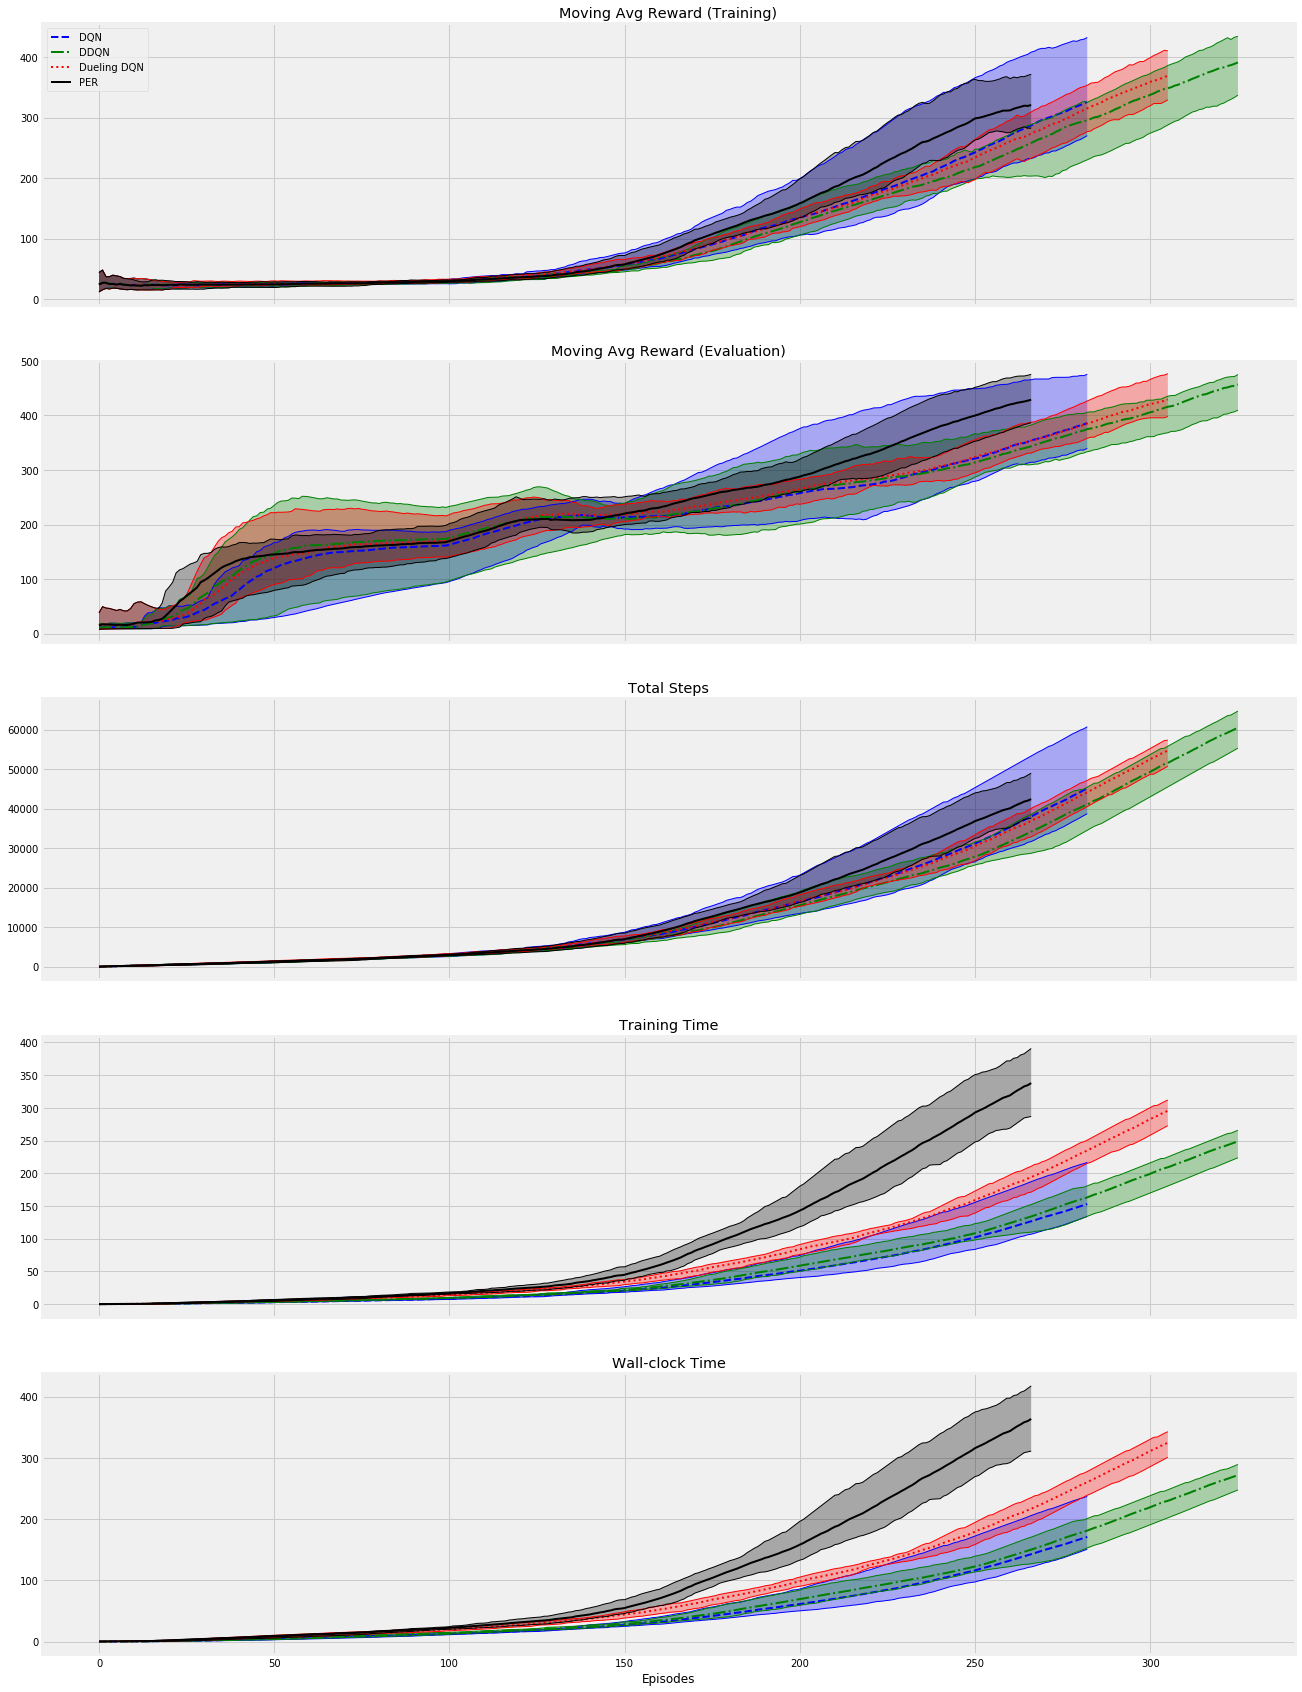

In [49]:
fig, axs = plt.subplots(5, 1, figsize=(20,30), sharey=False, sharex=True)

# NFQ
# axs[0].plot(nfq_max_r, 'y', linewidth=1)
# axs[0].plot(nfq_min_r, 'y', linewidth=1)
# axs[0].plot(nfq_mean_r, 'y', label='NFQ', linewidth=2)
# axs[0].fill_between(nfq_x, nfq_min_r, nfq_max_r, facecolor='y', alpha=0.3)
# 
# axs[1].plot(nfq_max_s, 'y', linewidth=1)
# axs[1].plot(nfq_min_s, 'y', linewidth=1)
# axs[1].plot(nfq_mean_s, 'y', label='NFQ', linewidth=2)
# axs[1].fill_between(nfq_x, nfq_min_s, nfq_max_s, facecolor='y', alpha=0.3)
# 
# axs[2].plot(nfq_max_t, 'y', linewidth=1)
# axs[2].plot(nfq_min_t, 'y', linewidth=1)
# axs[2].plot(nfq_mean_t, 'y', label='NFQ', linewidth=2)
# axs[2].fill_between(nfq_x, nfq_min_t, nfq_max_t, facecolor='y', alpha=0.3)
# 
# axs[3].plot(nfq_max_sec, 'y', linewidth=1)
# axs[3].plot(nfq_min_sec, 'y', linewidth=1)
# axs[3].plot(nfq_mean_sec, 'y', label='NFQ', linewidth=2)
# axs[3].fill_between(nfq_x, nfq_min_sec, nfq_max_sec, facecolor='y', alpha=0.3)
# 
# axs[4].plot(nfq_max_rt, 'y', linewidth=1)
# axs[4].plot(nfq_min_rt, 'y', linewidth=1)
# axs[4].plot(nfq_mean_rt, 'y', label='NFQ', linewidth=2)
# axs[4].fill_between(nfq_x, nfq_min_rt, nfq_max_rt, facecolor='y', alpha=0.3)

# DQN
axs[0].plot(dqn_max_r, 'b', linewidth=1)
axs[0].plot(dqn_min_r, 'b', linewidth=1)
axs[0].plot(dqn_mean_r, 'b--', label='DQN', linewidth=2)
axs[0].fill_between(dqn_x, dqn_min_r, dqn_max_r, facecolor='b', alpha=0.3)

axs[1].plot(dqn_max_s, 'b', linewidth=1)
axs[1].plot(dqn_min_s, 'b', linewidth=1)
axs[1].plot(dqn_mean_s, 'b--', label='DQN', linewidth=2)
axs[1].fill_between(dqn_x, dqn_min_s, dqn_max_s, facecolor='b', alpha=0.3)

axs[2].plot(dqn_max_t, 'b', linewidth=1)
axs[2].plot(dqn_min_t, 'b', linewidth=1)
axs[2].plot(dqn_mean_t, 'b--', label='DQN', linewidth=2)
axs[2].fill_between(dqn_x, dqn_min_t, dqn_max_t, facecolor='b', alpha=0.3)

axs[3].plot(dqn_max_sec, 'b', linewidth=1)
axs[3].plot(dqn_min_sec, 'b', linewidth=1)
axs[3].plot(dqn_mean_sec, 'b--', label='DQN', linewidth=2)
axs[3].fill_between(dqn_x, dqn_min_sec, dqn_max_sec, facecolor='b', alpha=0.3)

axs[4].plot(dqn_max_rt, 'b', linewidth=1)
axs[4].plot(dqn_min_rt, 'b', linewidth=1)
axs[4].plot(dqn_mean_rt, 'b--', label='DQN', linewidth=2)
axs[4].fill_between(dqn_x, dqn_min_rt, dqn_max_rt, facecolor='b', alpha=0.3)

# DDQN
axs[0].plot(ddqn_max_r, 'g', linewidth=1)
axs[0].plot(ddqn_min_r, 'g', linewidth=1)
axs[0].plot(ddqn_mean_r, 'g-.', label='DDQN', linewidth=2)
axs[0].fill_between(ddqn_x, ddqn_min_r, ddqn_max_r, facecolor='g', alpha=0.3)

axs[1].plot(ddqn_max_s, 'g', linewidth=1)
axs[1].plot(ddqn_min_s, 'g', linewidth=1)
axs[1].plot(ddqn_mean_s, 'g-.', label='DDQN', linewidth=2)
axs[1].fill_between(ddqn_x, ddqn_min_s, ddqn_max_s, facecolor='g', alpha=0.3)

axs[2].plot(ddqn_max_t, 'g', linewidth=1)
axs[2].plot(ddqn_min_t, 'g', linewidth=1)
axs[2].plot(ddqn_mean_t, 'g-.', label='DDQN', linewidth=2)
axs[2].fill_between(ddqn_x, ddqn_min_t, ddqn_max_t, facecolor='g', alpha=0.3)

axs[3].plot(ddqn_max_sec, 'g', linewidth=1)
axs[3].plot(ddqn_min_sec, 'g', linewidth=1)
axs[3].plot(ddqn_mean_sec, 'g-.', label='DDQN', linewidth=2)
axs[3].fill_between(ddqn_x, ddqn_min_sec, ddqn_max_sec, facecolor='g', alpha=0.3)

axs[4].plot(ddqn_max_rt, 'g', linewidth=1)
axs[4].plot(ddqn_min_rt, 'g', linewidth=1)
axs[4].plot(ddqn_mean_rt, 'g-.', label='DDQN', linewidth=2)
axs[4].fill_between(ddqn_x, ddqn_min_rt, ddqn_max_rt, facecolor='g', alpha=0.3)

# Dueling DQN
axs[0].plot(dueling_dqn_max_r, 'r', linewidth=1)
axs[0].plot(dueling_dqn_min_r, 'r', linewidth=1)
axs[0].plot(dueling_dqn_mean_r, 'r:', label='Dueling DQN', linewidth=2)
axs[0].fill_between(
    dueling_dqn_x, dueling_dqn_min_r, dueling_dqn_max_r, facecolor='r', alpha=0.3)

axs[1].plot(dueling_dqn_max_s, 'r', linewidth=1)
axs[1].plot(dueling_dqn_min_s, 'r', linewidth=1)
axs[1].plot(dueling_dqn_mean_s, 'r:', label='Dueling DQN', linewidth=2)
axs[1].fill_between(
    dueling_dqn_x, dueling_dqn_min_s, dueling_dqn_max_s, facecolor='r', alpha=0.3)

axs[2].plot(dueling_dqn_max_t, 'r', linewidth=1)
axs[2].plot(dueling_dqn_min_t, 'r', linewidth=1)
axs[2].plot(dueling_dqn_mean_t, 'r:', label='Dueling DQN', linewidth=2)
axs[2].fill_between(
    dueling_dqn_x, dueling_dqn_min_t, dueling_dqn_max_t, facecolor='r', alpha=0.3)

axs[3].plot(dueling_dqn_max_sec, 'r', linewidth=1)
axs[3].plot(dueling_dqn_min_sec, 'r', linewidth=1)
axs[3].plot(dueling_dqn_mean_sec, 'r:', label='Dueling DQN', linewidth=2)
axs[3].fill_between(
    dueling_dqn_x, dueling_dqn_min_sec, dueling_dqn_max_sec, facecolor='r', alpha=0.3)

axs[4].plot(dueling_dqn_max_rt, 'r', linewidth=1)
axs[4].plot(dueling_dqn_min_rt, 'r', linewidth=1)
axs[4].plot(dueling_dqn_mean_rt, 'r:', label='Dueling DQN', linewidth=2)
axs[4].fill_between(
    dueling_dqn_x, dueling_dqn_min_rt, dueling_dqn_max_rt, facecolor='r', alpha=0.3)

# PER
axs[0].plot(per_max_r, 'k', linewidth=1)
axs[0].plot(per_min_r, 'k', linewidth=1)
axs[0].plot(per_mean_r, 'k', label='PER', linewidth=2)
axs[0].fill_between(per_x, per_min_r, per_max_r, facecolor='k', alpha=0.3)

axs[1].plot(per_max_s, 'k', linewidth=1)
axs[1].plot(per_min_s, 'k', linewidth=1)
axs[1].plot(per_mean_s, 'k', label='PER', linewidth=2)
axs[1].fill_between(per_x, per_min_s, per_max_s, facecolor='k', alpha=0.3)

axs[2].plot(per_max_t, 'k', linewidth=1)
axs[2].plot(per_min_t, 'k', linewidth=1)
axs[2].plot(per_mean_t, 'k', label='PER', linewidth=2)
axs[2].fill_between(per_x, per_min_t, per_max_t, facecolor='k', alpha=0.3)

axs[3].plot(per_max_sec, 'k', linewidth=1)
axs[3].plot(per_min_sec, 'k', linewidth=1)
axs[3].plot(per_mean_sec, 'k', label='PER', linewidth=2)
axs[3].fill_between(per_x, per_min_sec, per_max_sec, facecolor='k', alpha=0.3)

axs[4].plot(per_max_rt, 'k', linewidth=1)
axs[4].plot(per_min_rt, 'k', linewidth=1)
axs[4].plot(per_mean_rt, 'k', label='PER', linewidth=2)
axs[4].fill_between(per_x, per_min_rt, per_max_rt, facecolor='k', alpha=0.3)

# ALL
axs[0].set_title('Moving Avg Reward (Training)')
axs[1].set_title('Moving Avg Reward (Evaluation)')
axs[2].set_title('Total Steps')
axs[3].set_title('Training Time')
axs[4].set_title('Wall-clock Time')
plt.xlabel('Episodes')
axs[0].legend(loc='upper left')
plt.show()